In [2]:
#!pip install timesynth
# TIMESYNTH TO GENERATE TIME SERIESES
import ts_syntheticData
from ts_syntheticData import insert_anomalies
# CUSTOM DEFINED DATALOADERS AND MODELS
from ts_dataloader import get_datasets, load_data
from ts_training import train_network
from ts_VI_LSTM import Variational_LSTM, loss_normal2d
from ts_simple_LSTM_net import Standard_LSTM, loss_function_normal
from ts_anomaly_function import detect_anomalies, detect_anomalies_VAE
# PYTORCH
import torch
from torch import optim, distributions
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
# MATPLOTLIB NUMPY
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
import math

In [3]:
def plot_anomalies(anomaly_data, sequence, A=0, B=1000):

    labels = anomaly_data["outlier_label"]
    if sequence.shape[0] != len(labels):
        raise ValueError("The length of the sequence and the number of labels whould be the same.")
    
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    figures= []
    for dimension in range(sequence.shape[1]):

        fig = plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        for t in range(Ti, Tf-1):
            plt.plot(t, sequence[t, dimension], 'o', color="red" if labels[t] else "blue", markersize = 6 if labels[t] else 2)
        plt.plot(time_axis, sequence[Ti:Tf-1,dimension], label = "Real data")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.legend()
        figures.append(fig)
        plt.show()
    
    return figures

In [4]:
def save_setup(run_name, \
               raw_signals, train_dataset, valid_dataset, test_dataset, net_state_dict_VAE, net_state_dict_LSTM, \
               anomalies_figures_LSTM, anomalies_figures_VAE, output_figures_LSTM, output_figures_VAE, \
               train_fig_LSTM, train_fig_VAE, \
               epochs_LSTM, hidden_layer_size, \
               epochs_VAE, params_distribution, hidden_dim_gen, hidden_dim_rec, latent_dim, \
               anomalies_m, anomalies_p, \
               accuracy_LSTM, accuracy_VAE):
    import os
    import numpy as np
    from datetime import datetime

    now = datetime.now()

    path = "runs/"+now.strftime("%Y%m%d_%H%M-")+run_name
    try:
        os.mkdir(path)
    except OSError:
        print ("Creation of the directory %s failed" % path)
        print(OSError)
    else:
        print ("Successfully created the directory %s " % path)

    train_signals, train_labels = train_dataset.get_data()
    valid_signals, valid_labels = valid_dataset.get_data()
    test_signals,  test_labels  = test_dataset.get_data()
    
    np.save(path+"/train_signals", train_signals.numpy())
    np.save(path+"/valid_signals", valid_signals.numpy())
    np.save(path+"/test_signals", test_signals.numpy())
    config_str = ""
    if train_dataset.has_labels():
        config_str += "Labelled \n"
        config_str += "Anomalies magnitude: "+str(anomalies_m)+"\n"
        config_str += "Anomalies probability: "+str(anomalies_p)+"\n"
        np.save(path+"/train_labels", train_labels.numpy())
        np.save(path+"/valid_labels", valid_labels.numpy())
        np.save(path+"/test_labels", test_labels.numpy())
    else:
        config_str += "Not labelled \n"
        config_str += "Anomalies magnitude: 0\n"
        config_str += "Anomalies probability: 0\n"

    train_fig_LSTM.savefig(path+"/training_LSTM.pdf")
    train_fig_VAE.savefig(path+"/training_VAE.pdf")
    
    for i,figure in enumerate(anomalies_figures_LSTM):
        figure.savefig(path+"/results_anomaly_LSTM_"+str(i)+".pdf")
    for i,figure in enumerate(anomalies_figures_VAE):
        figure.savefig(path+"/results_anomaly_VAE_"+str(i)+".pdf")
    for i,figure in enumerate(output_figures_LSTM):
        figure.savefig(path+"/output_model_LSTM_"+str(i)+".pdf")
    for i,figure in enumerate(output_figures_VAE):
        figure.savefig(path+"/output_model_VAE_"+str(i)+".pdf")
    
    config_str += "Params out distrib: "+ str(params_distribution) + "\n"
    config_str += "LSTM\n"
    config_str += "Epochs: "+str(epochs_LSTM)+"\n"
    config_str += "Hidden_dim: "+str(hidden_layer_size)+"\n"
    config_str += str(accuracy_LSTM)+"\n"
    config_str += "VAE\n"
    config_str += "Epochs: "+str(epochs_VAE)+"\n"
    config_str += "Hidden dim gen: "+str(hidden_dim_gen)+"\n"
    config_str += "Hidden dim rec: "+str(hidden_dim_rec)+"\n"
    config_str += "Latent dim: "+str(latent_dim)+"\n"
    config_str += str(accuracy_VAE)+"\n"
    
    
    with open(path+"/configs.txt", "w") as f:
        f.write(config_str)

        

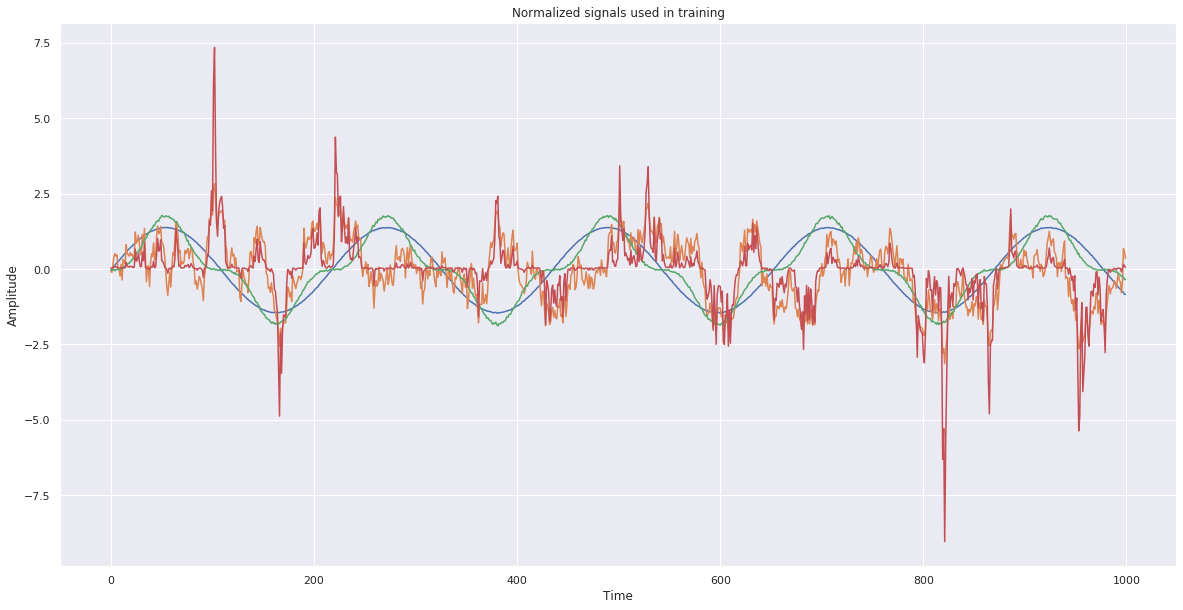

In [5]:
#USEDATASET = 0  # simple synthetic dataset
USEDATASET = 1 # correlated synthetic dataset
#USEDATASET = 2 # realistic weather dataset

# anomaly parameters
add_anomalies = False
if (USEDATASET == 0) or (USEDATASET == 1):
    add_anomalies = True
# anomaly probability
anomalies_p = 0.001
# anomaly magnitude
anomalies_m = 5


# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

# number of samples in the time series
train_T = 1000
valid_T = 1000
test_T = 500
# width of the window of each time series
W = 1000
# check for inconsistency
if W > train_T:
    raise ValueError("The time window cannot be longer than the training data sequence available.")

T = train_T + valid_T + test_T
# the size of train and validation, test is the remainder of the data
t_v_t_split = [train_T/T,valid_T/T]

#load the data in, this is supposed to happen only once
raw_signals = load_data(USEDATASET, T)

if add_anomalies:
    timeseries_signals, timeseries_labels = insert_anomalies(raw_signals, magnitude=anomalies_m, p=anomalies_p)
else:
    timeseries_signals = raw_signals
    timeseries_labels = None

features, train_dataset, valid_dataset, test_dataset = get_datasets(USEDATASET, t_v_t_split, W, device, timeseries_signals, timeseries_labels)

train_timeseries_signals = train_dataset.get_data()[0]
plt.figure(figsize = (20,10))
plt.title("Normalized signals used in training")
plt.plot(list(range(len(train_timeseries_signals))), train_timeseries_signals)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [6]:
device

device(type='cpu')

In [7]:
# Here we can change to batch size
# batch size (number of serieses of length W)
B = 1
# check for consistency, we don't want to pad the sequence if possible
if (train_T - W + 1) % B != 0 :
    raise ValueError("The batch size chosen will result in different sized batches during training")

# create the Synthetic Dataset
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=False)
#valid_loader = DataLoader(valid_dataset, shuffle=False)
#seq_loader = DataLoader(valid_dataset, shuffle=False)
#test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# VI approach

Training has started.
Epoch: 0


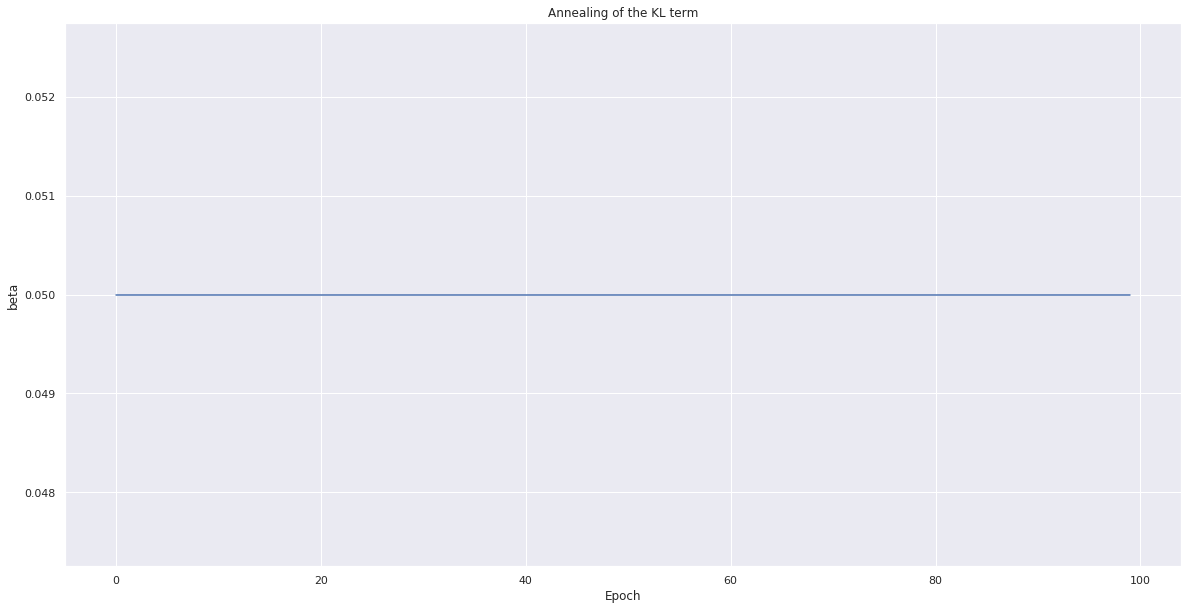

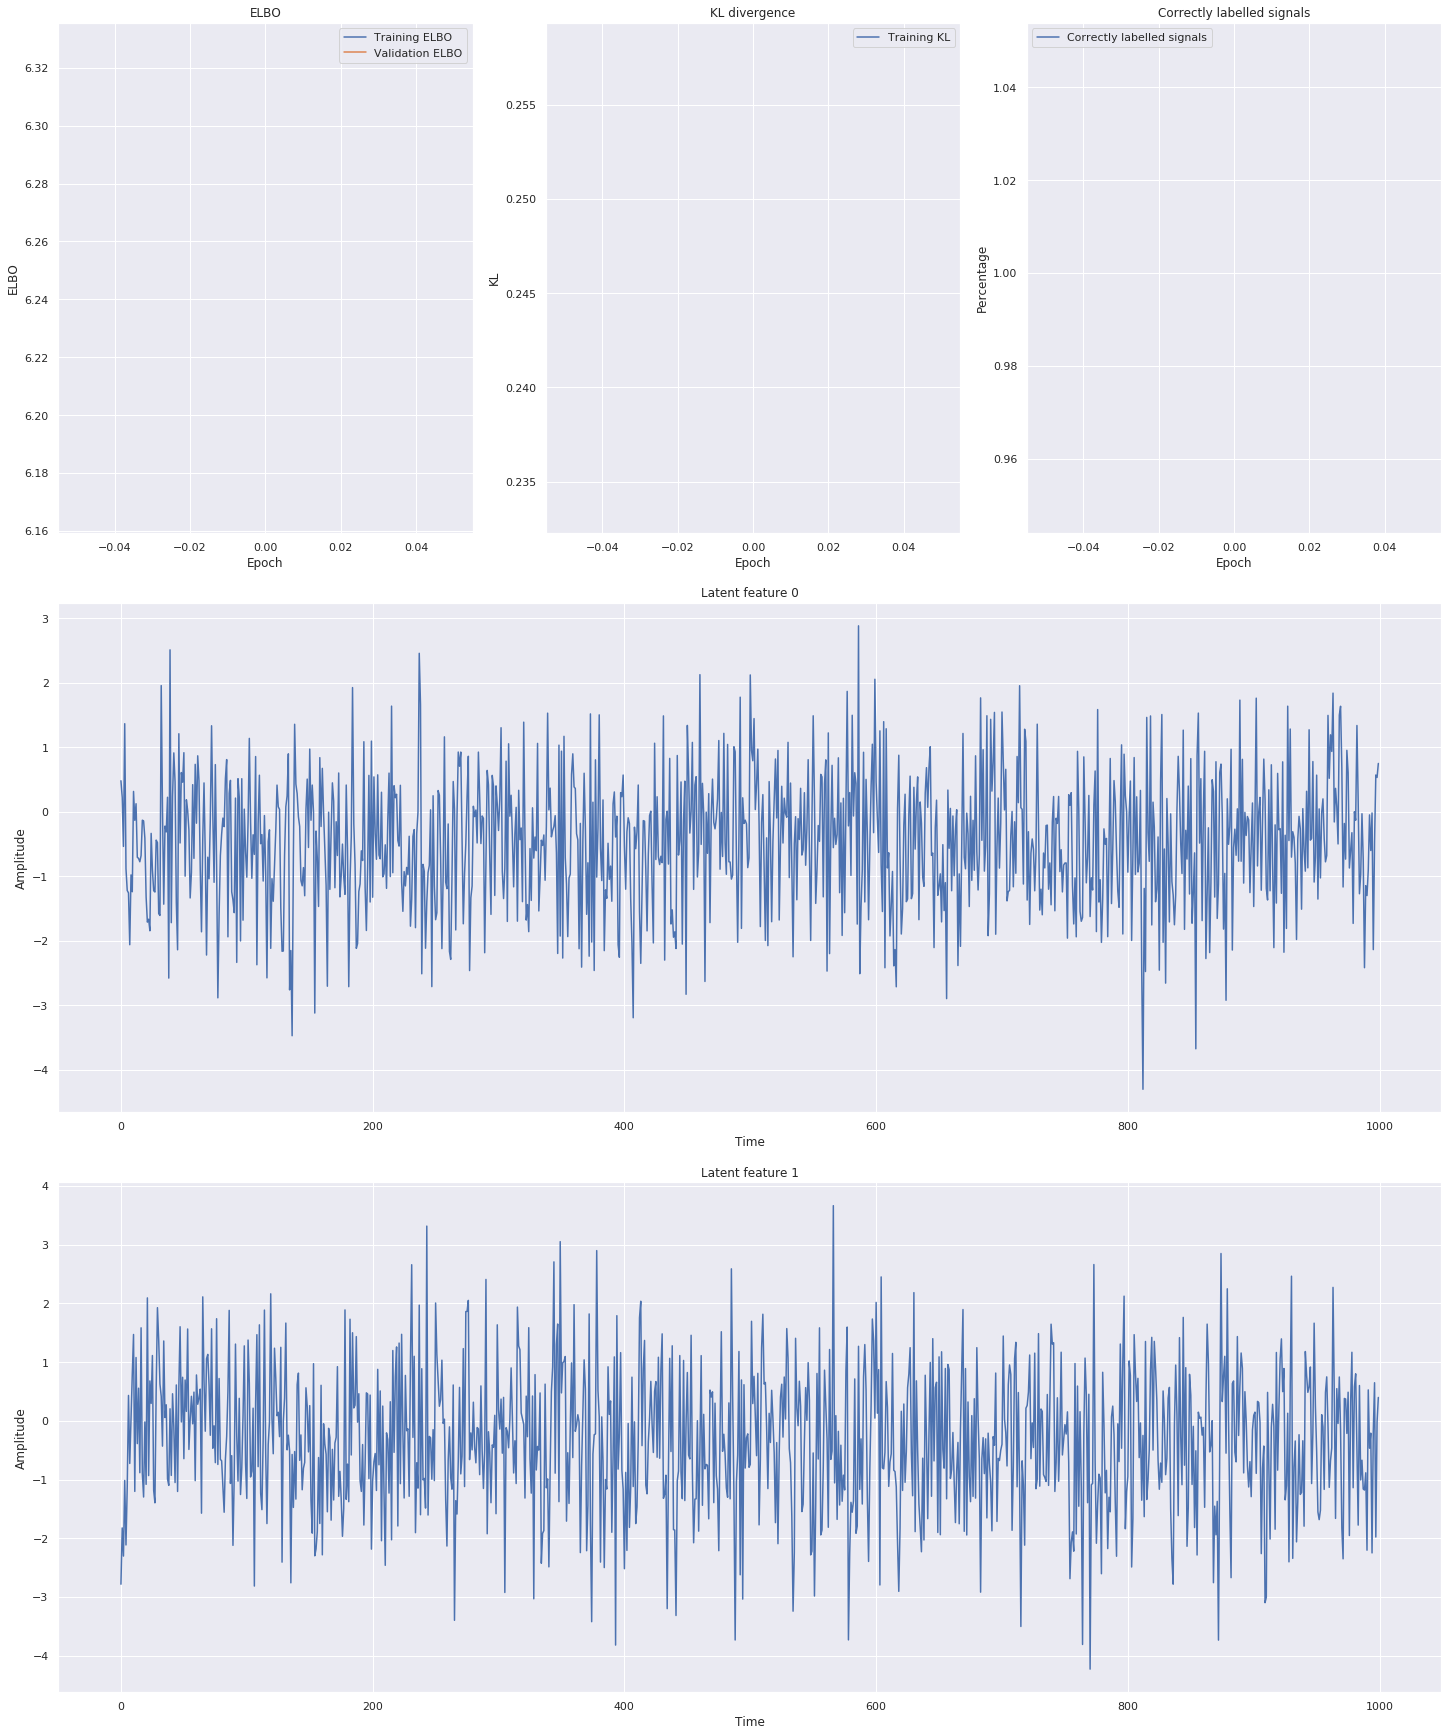

Epoch: 9


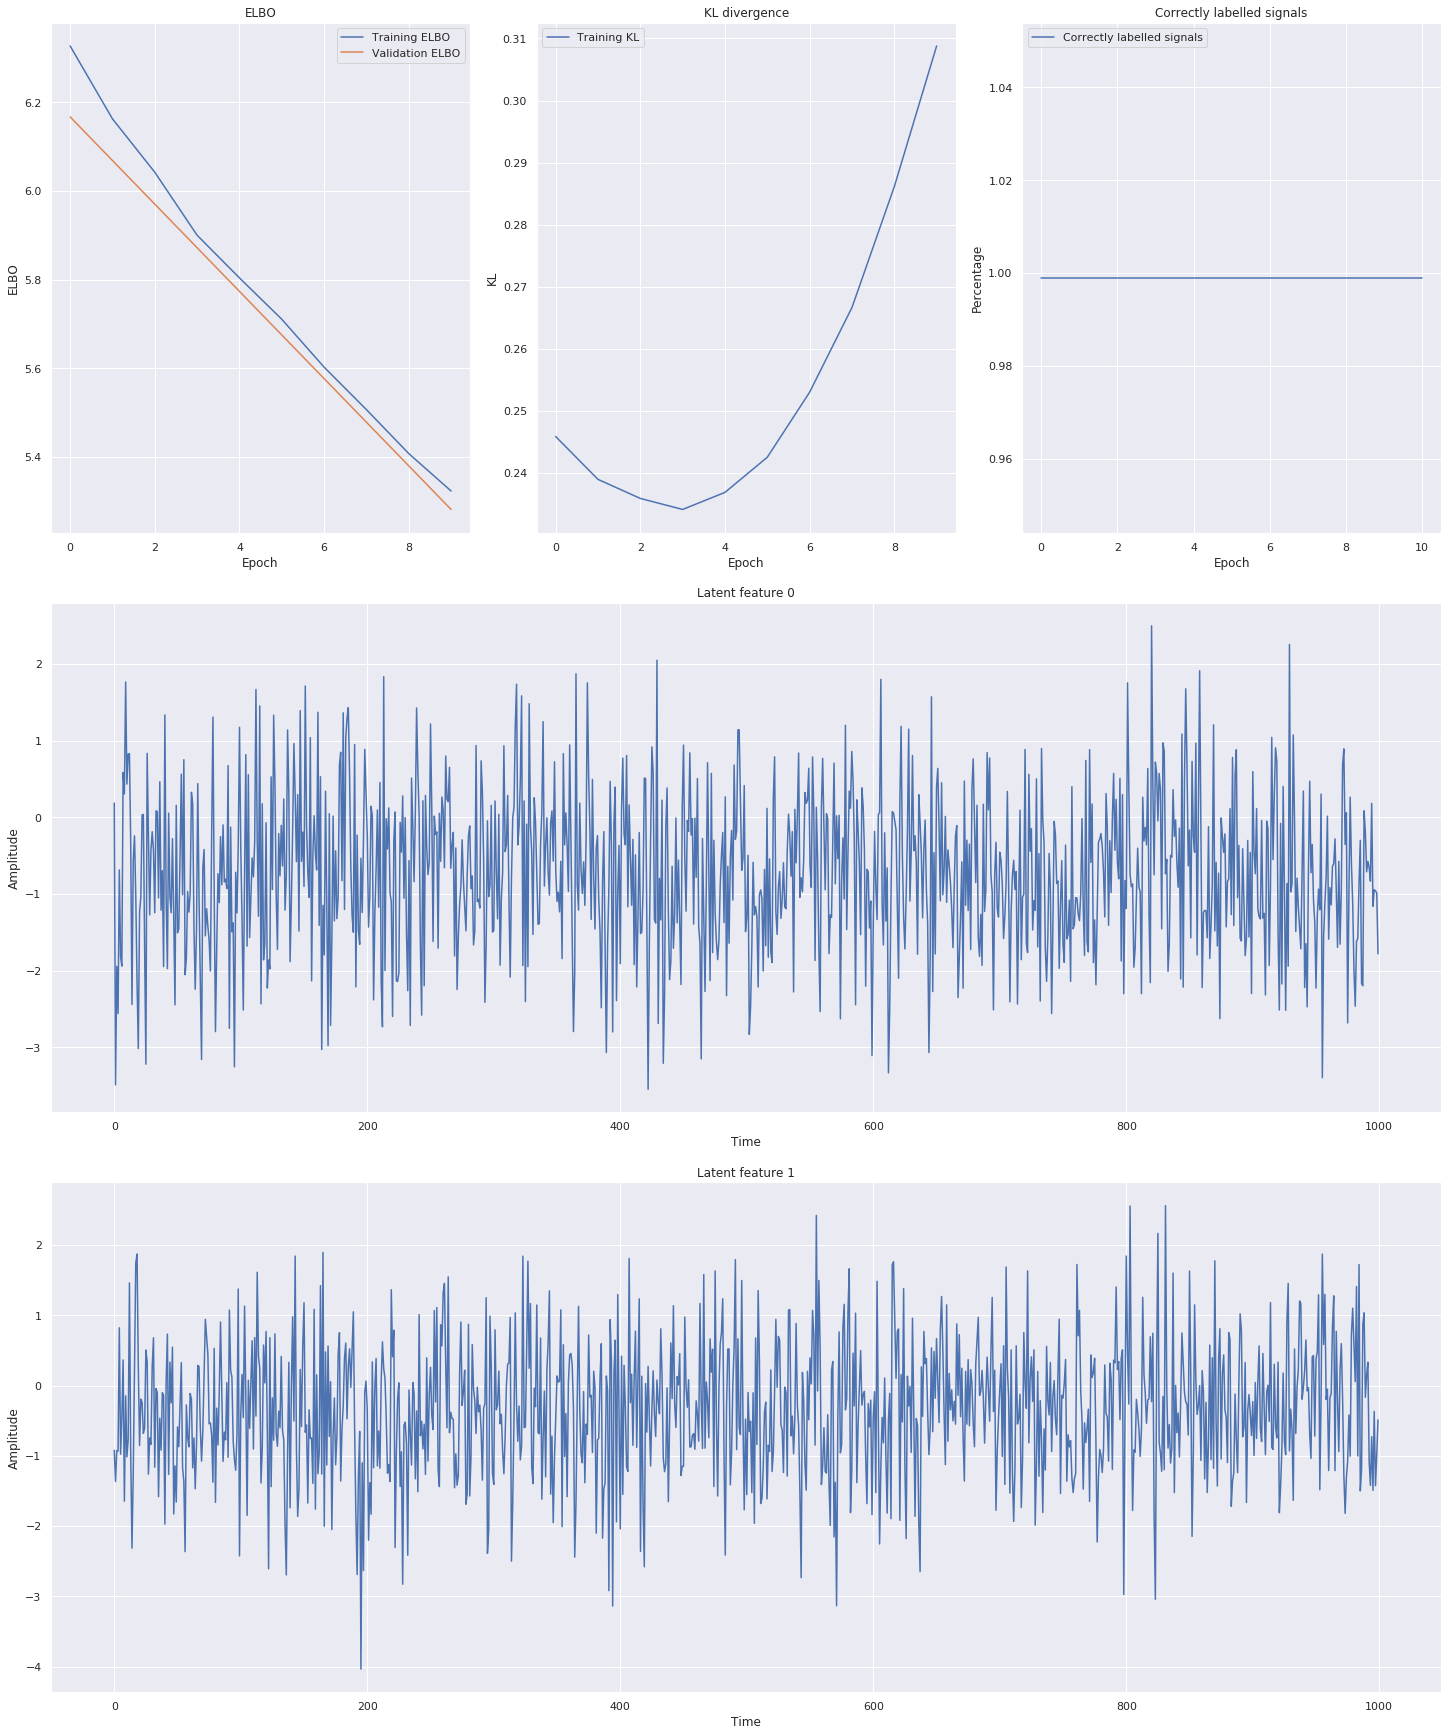

Epoch: 19


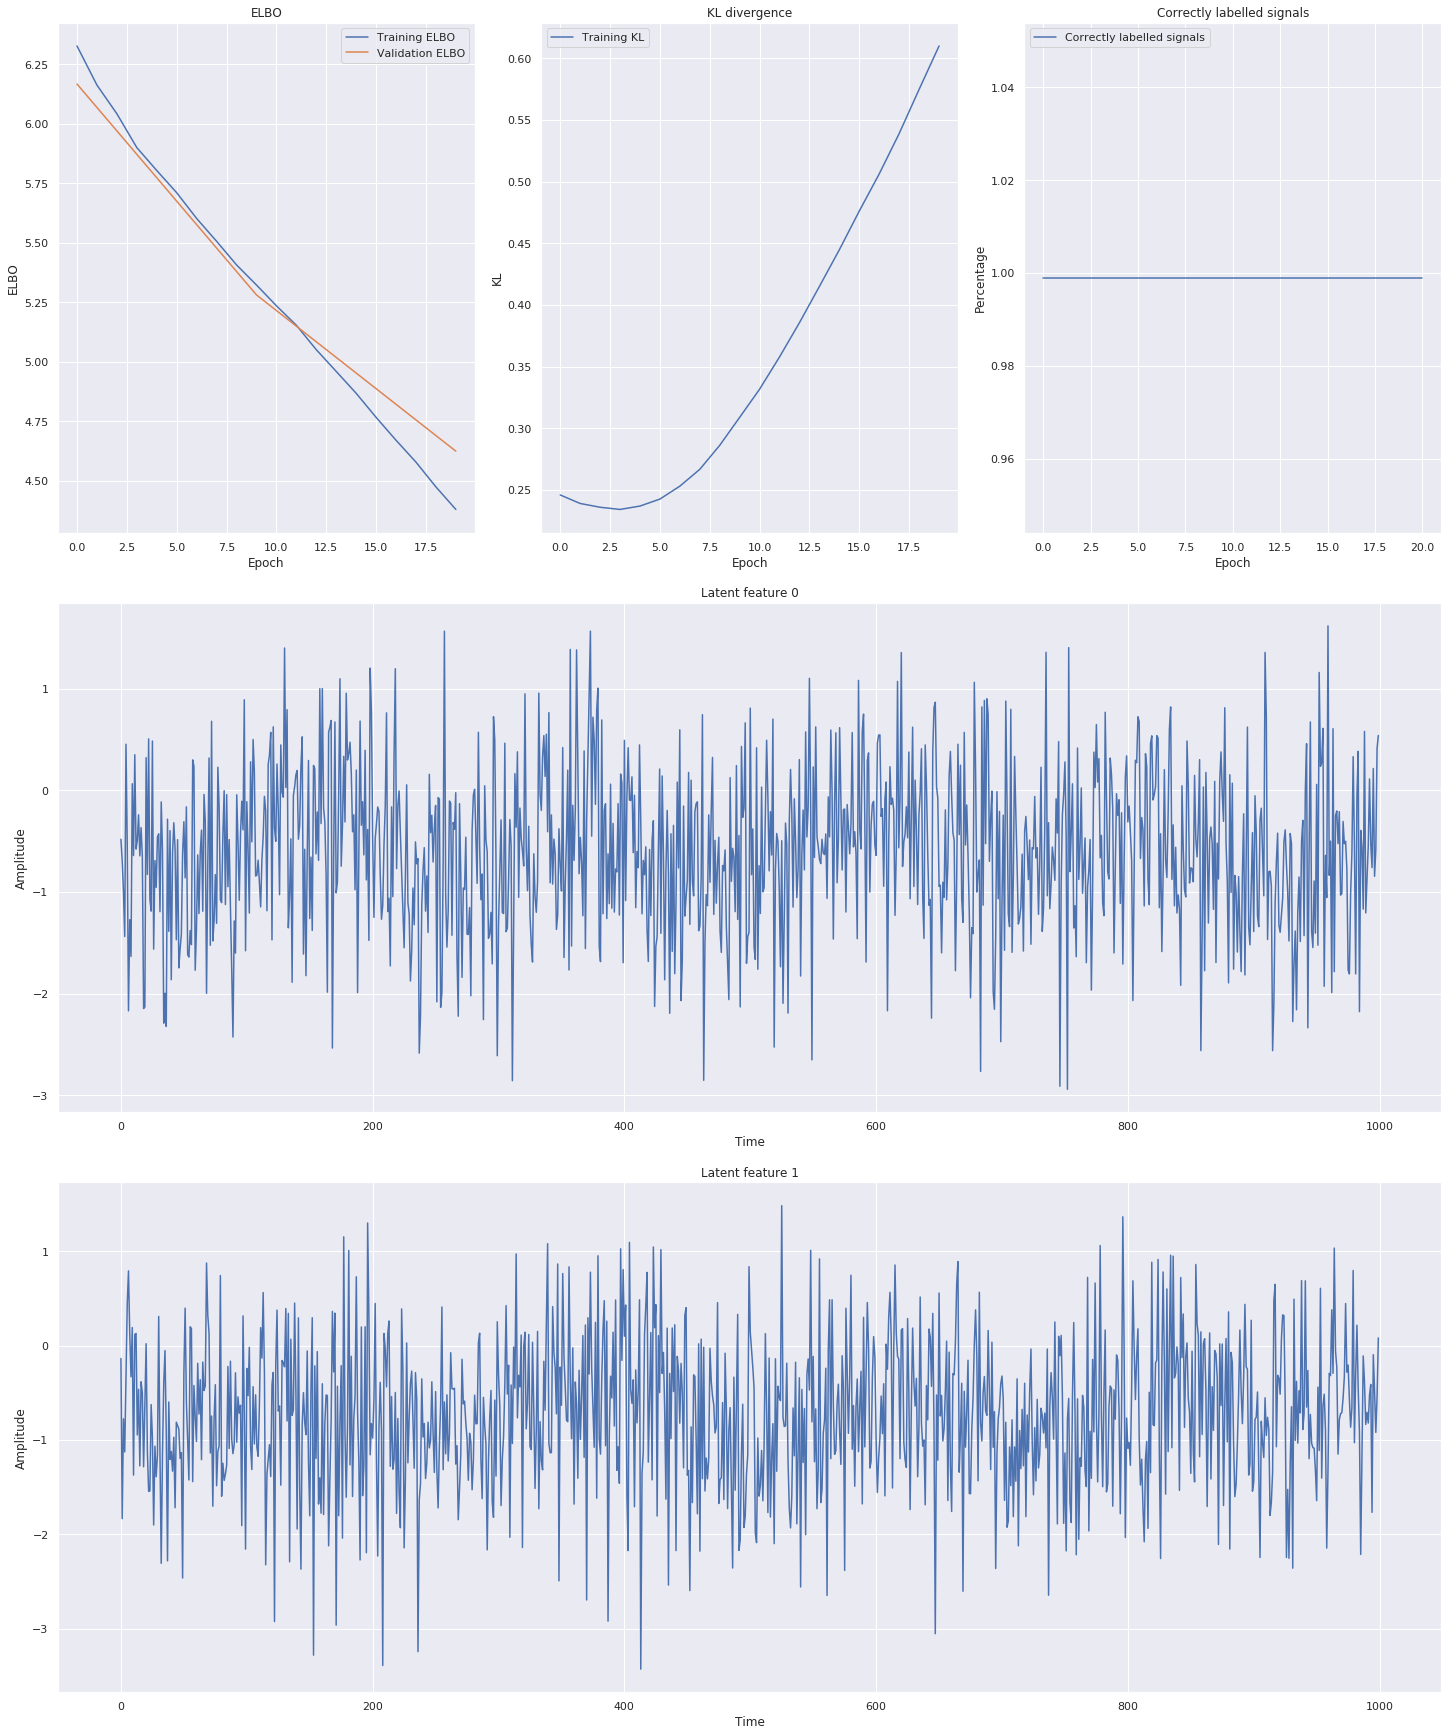

Epoch: 29


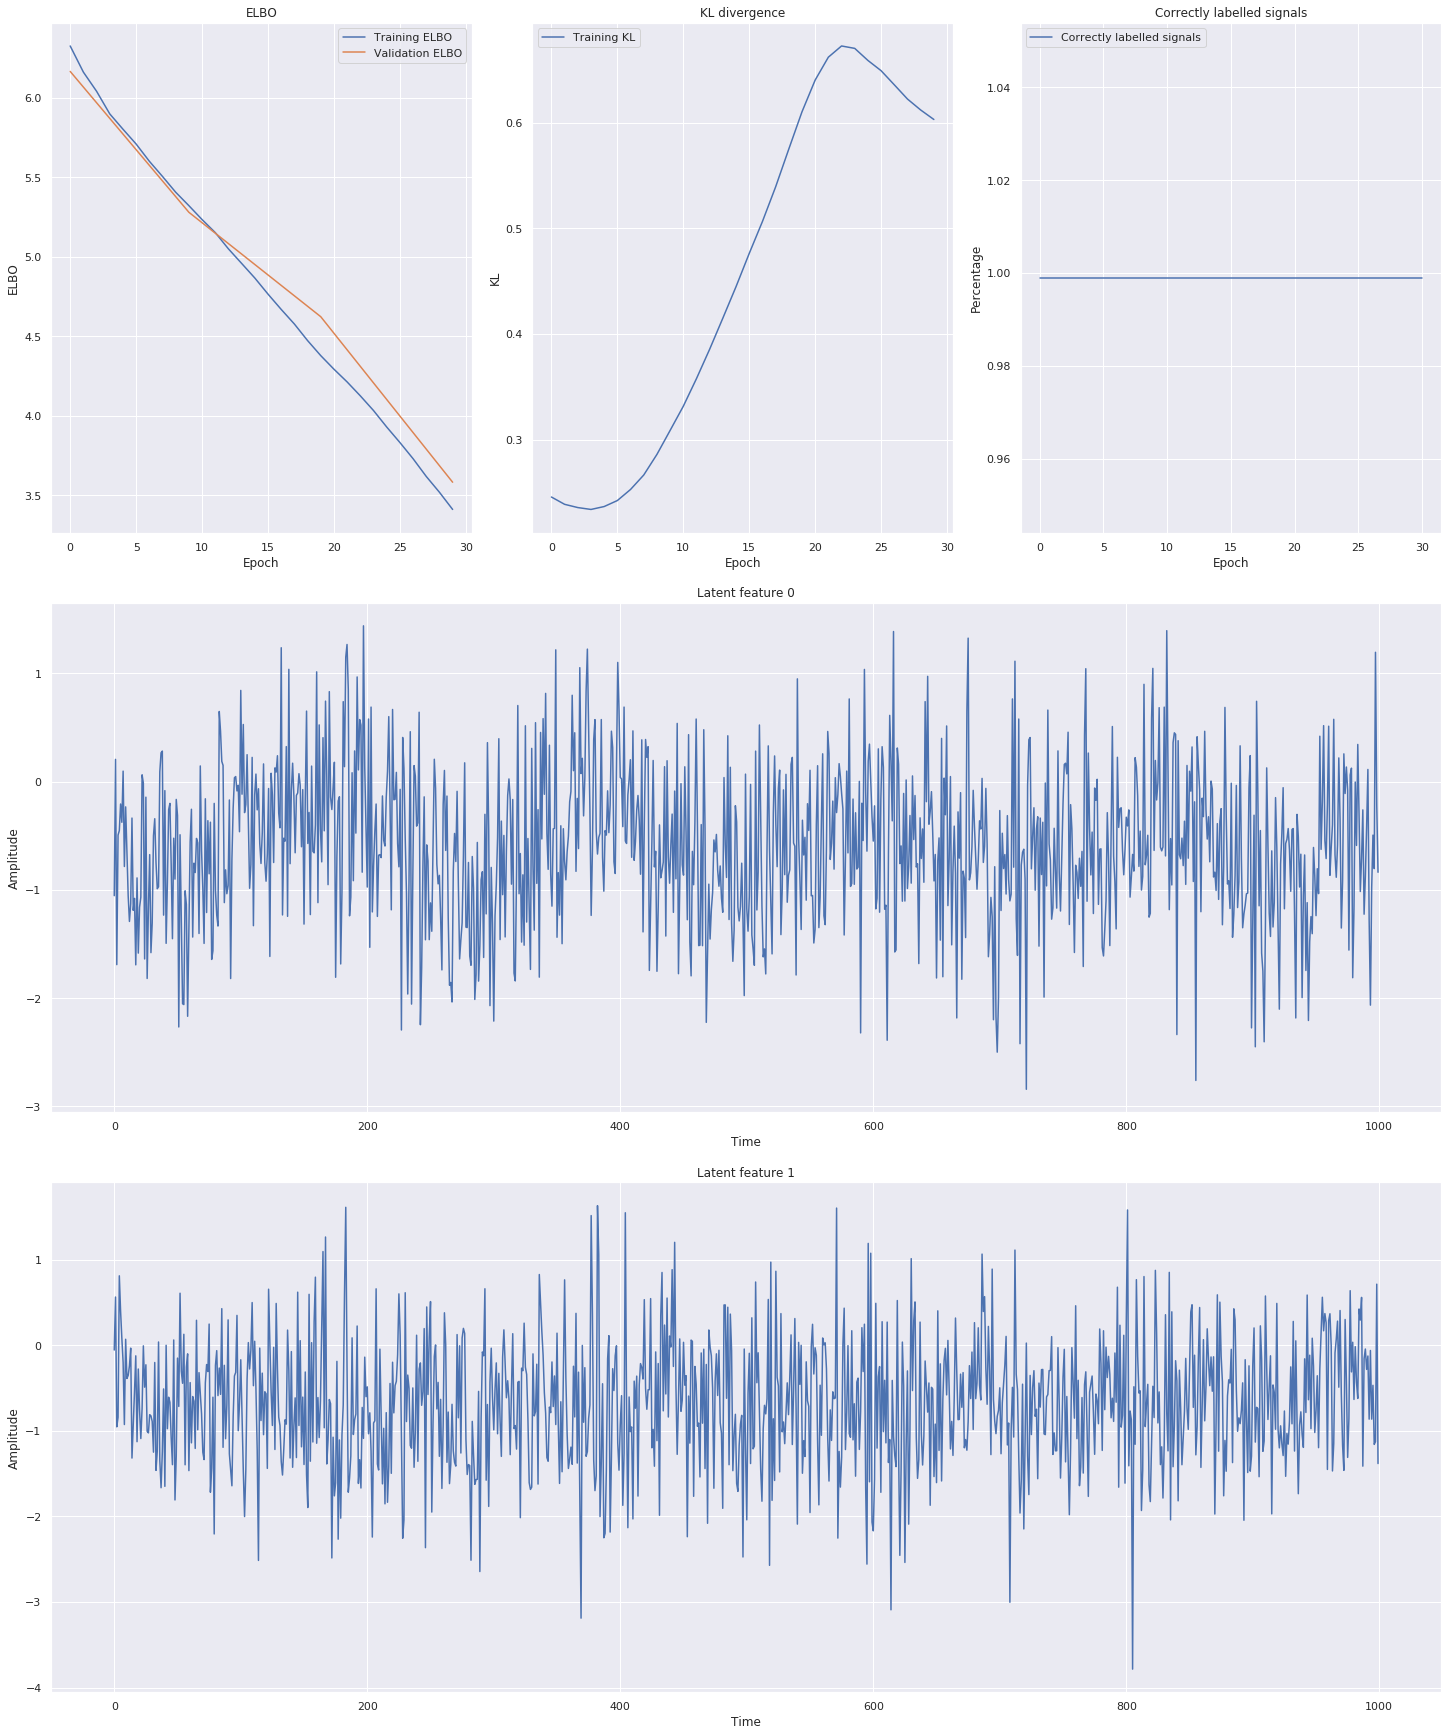

Epoch: 39


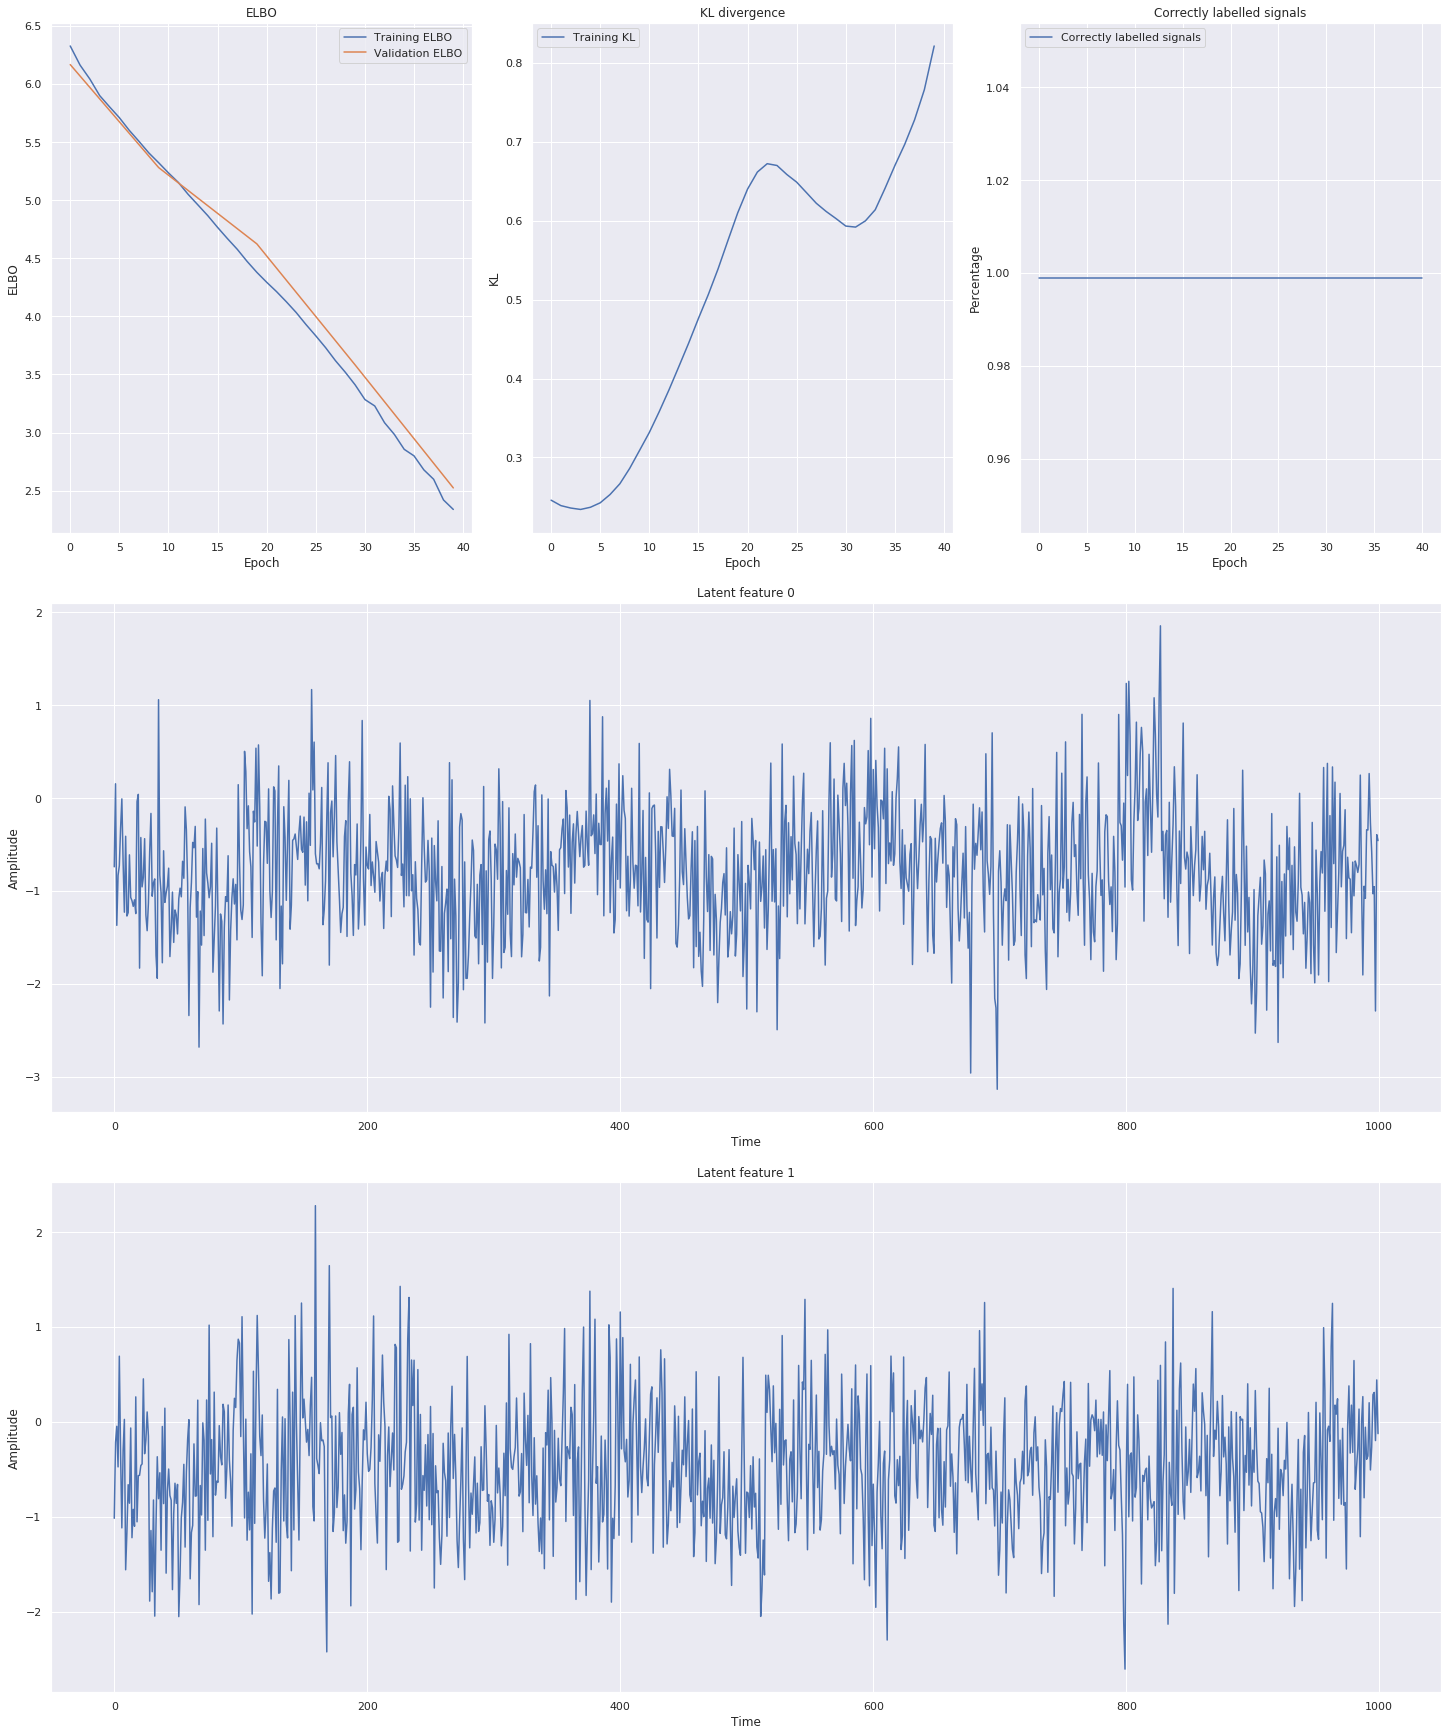

Epoch: 49


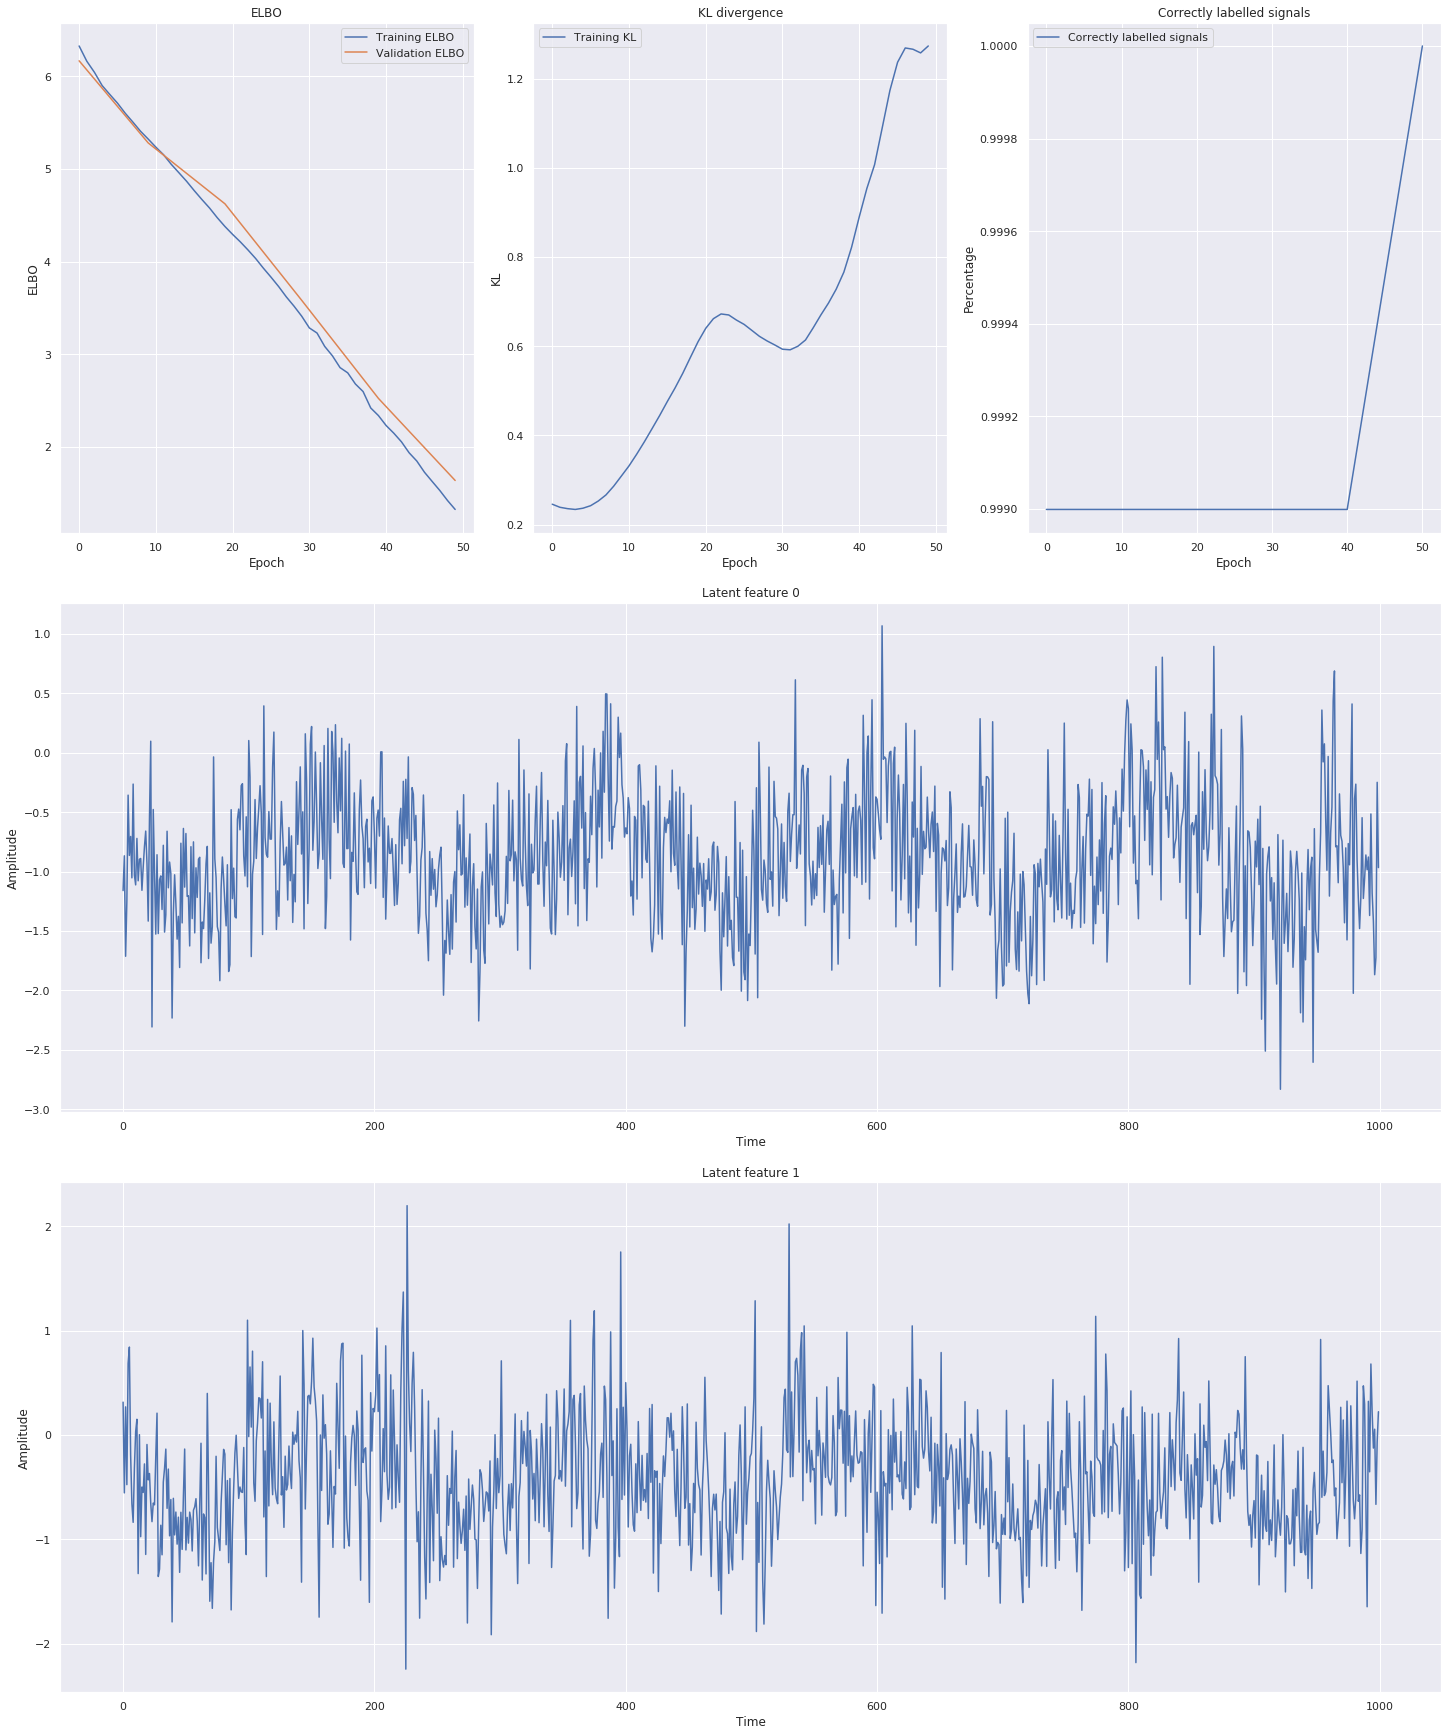

Epoch: 59


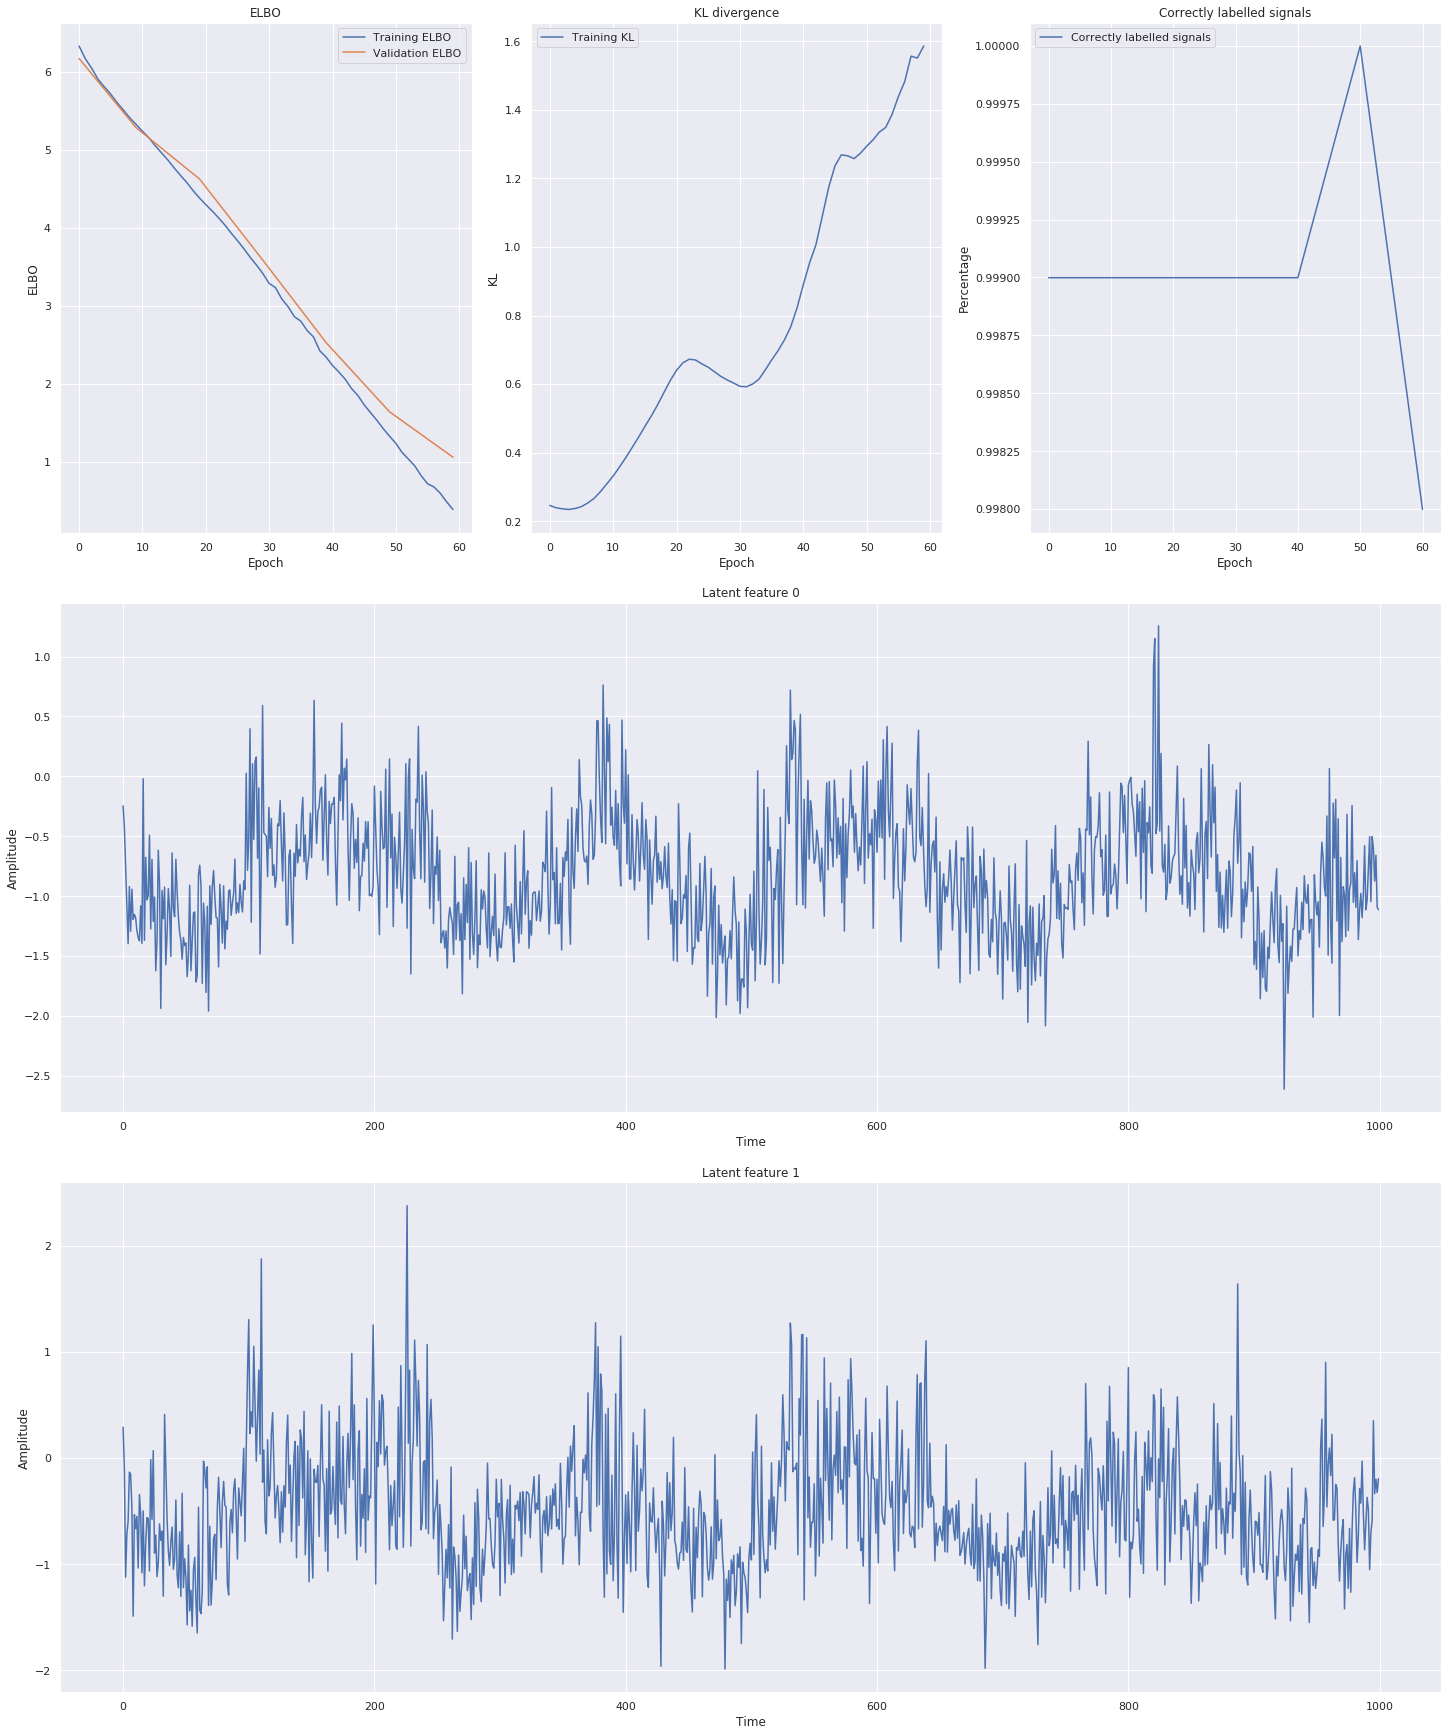

Epoch: 69


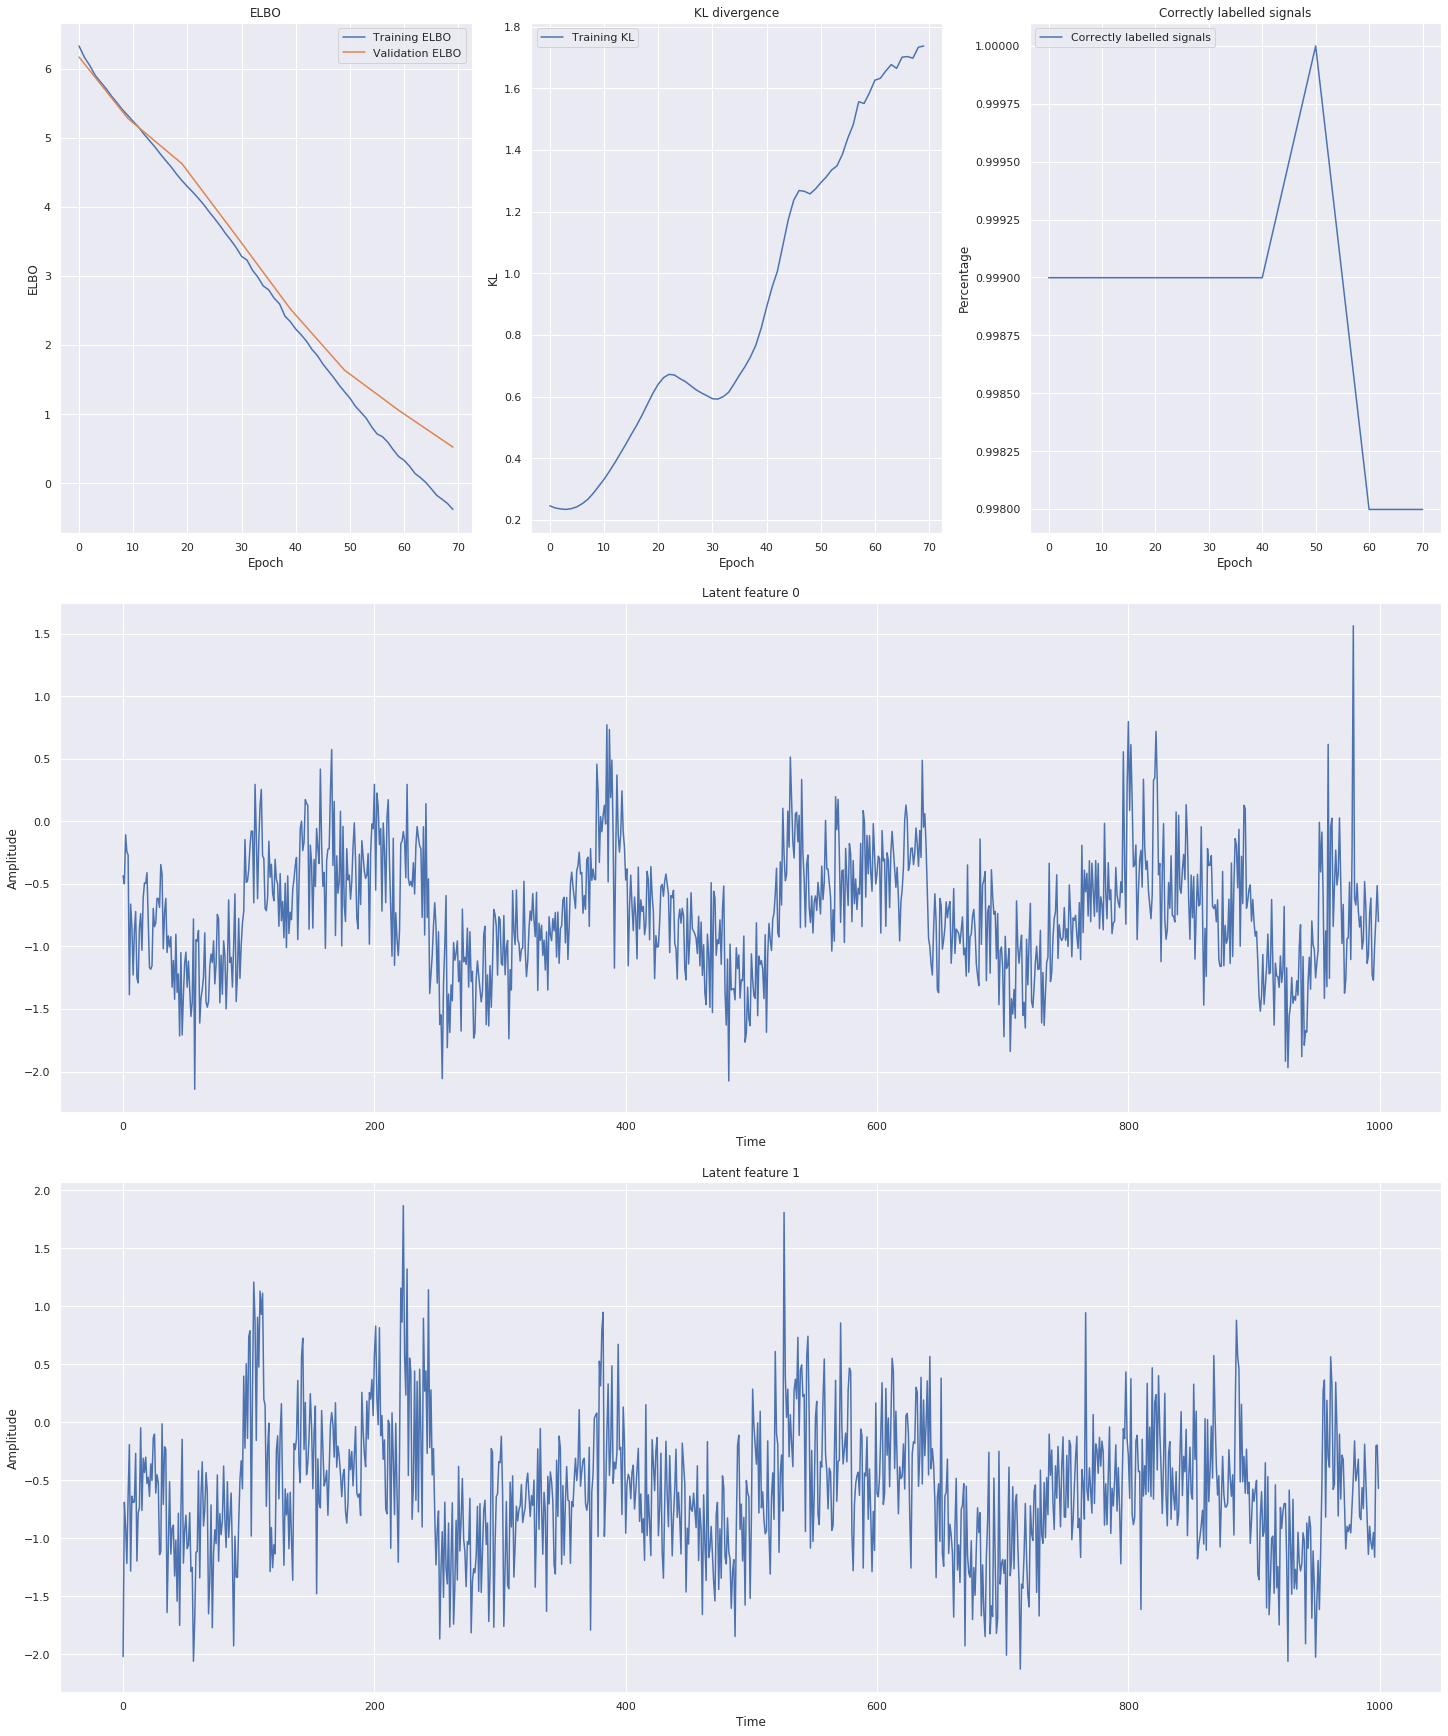

Epoch: 79


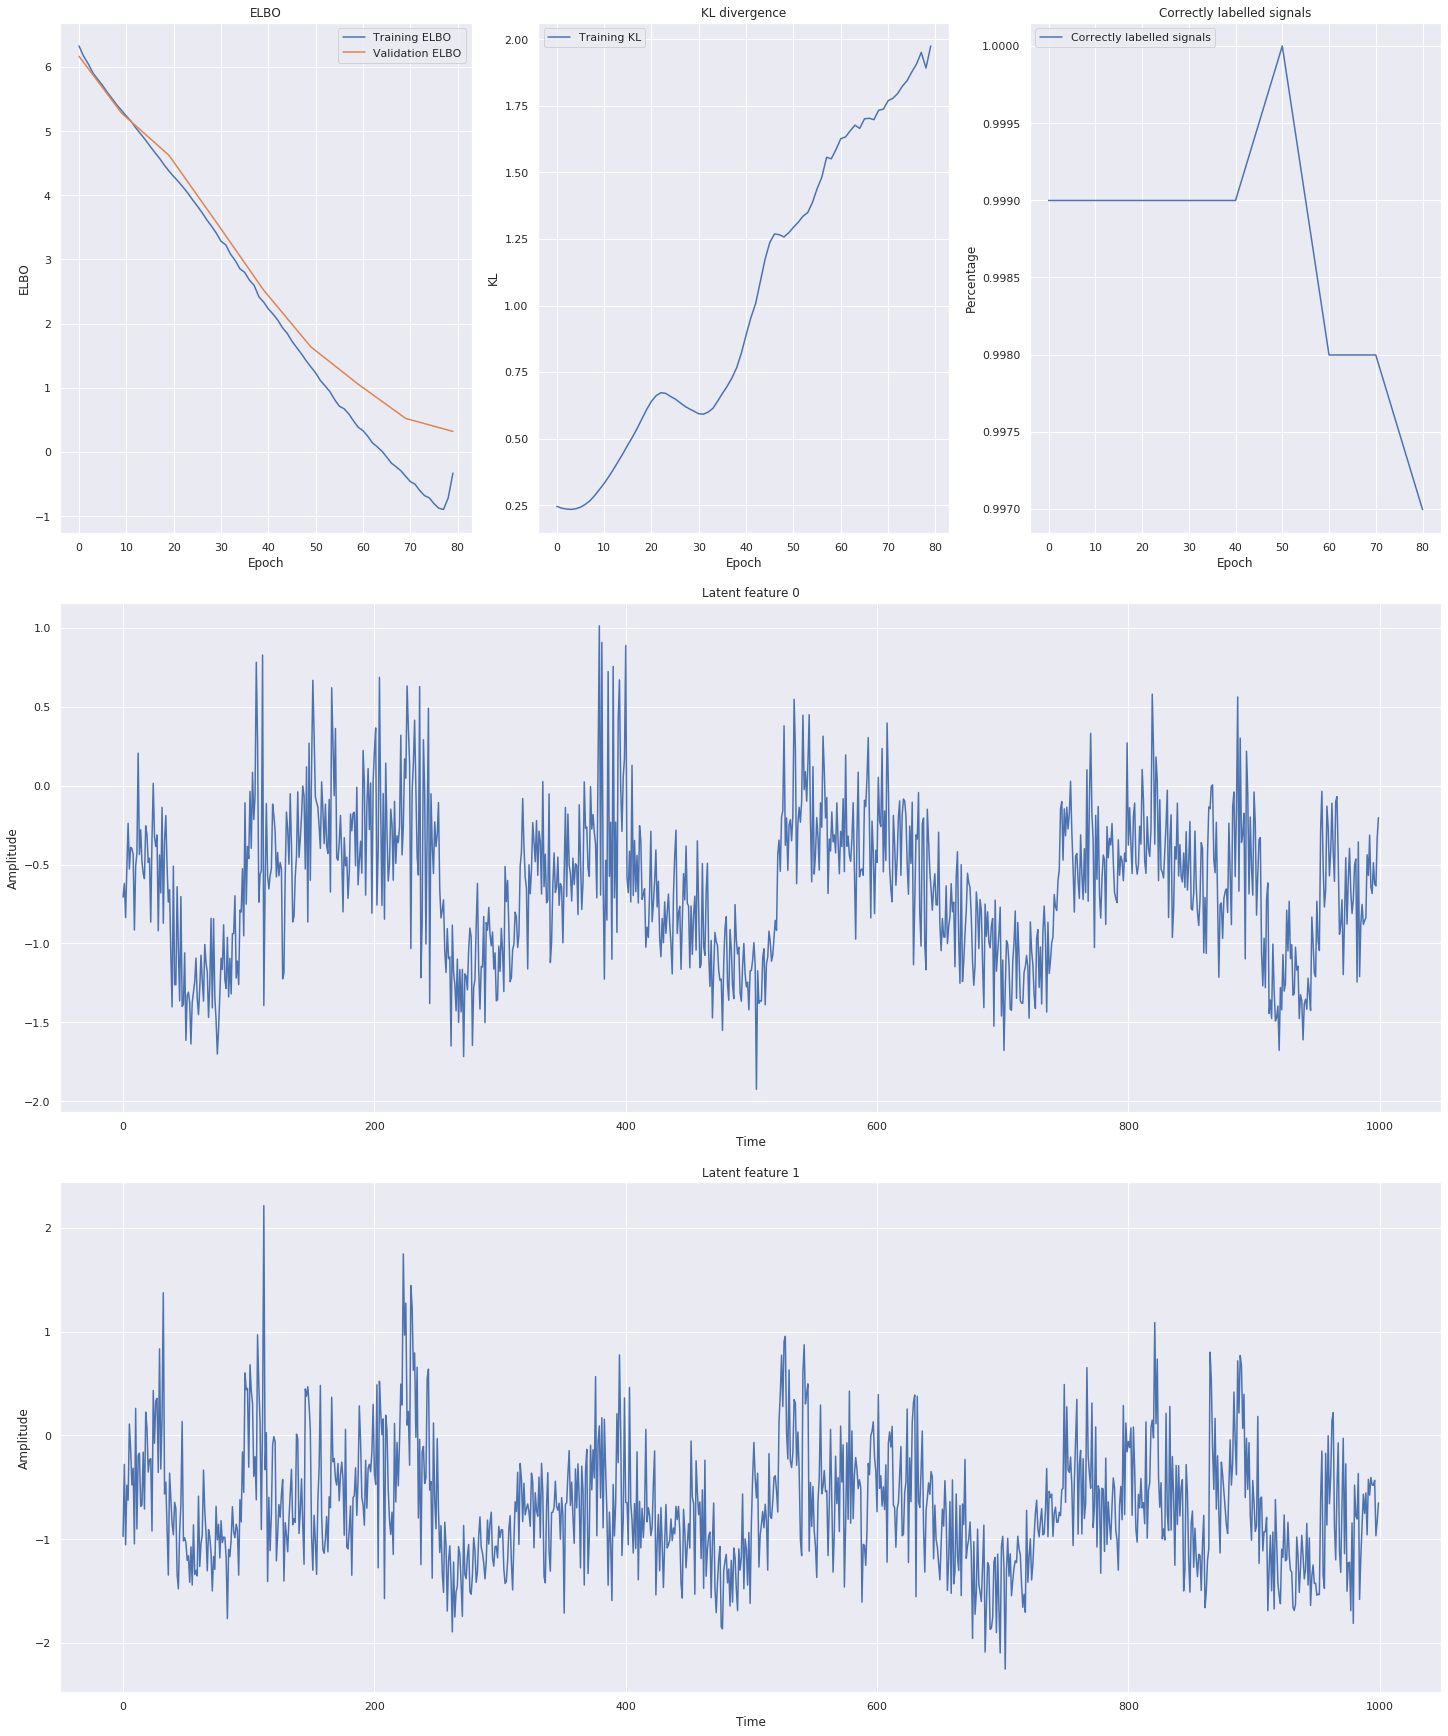

Epoch: 89


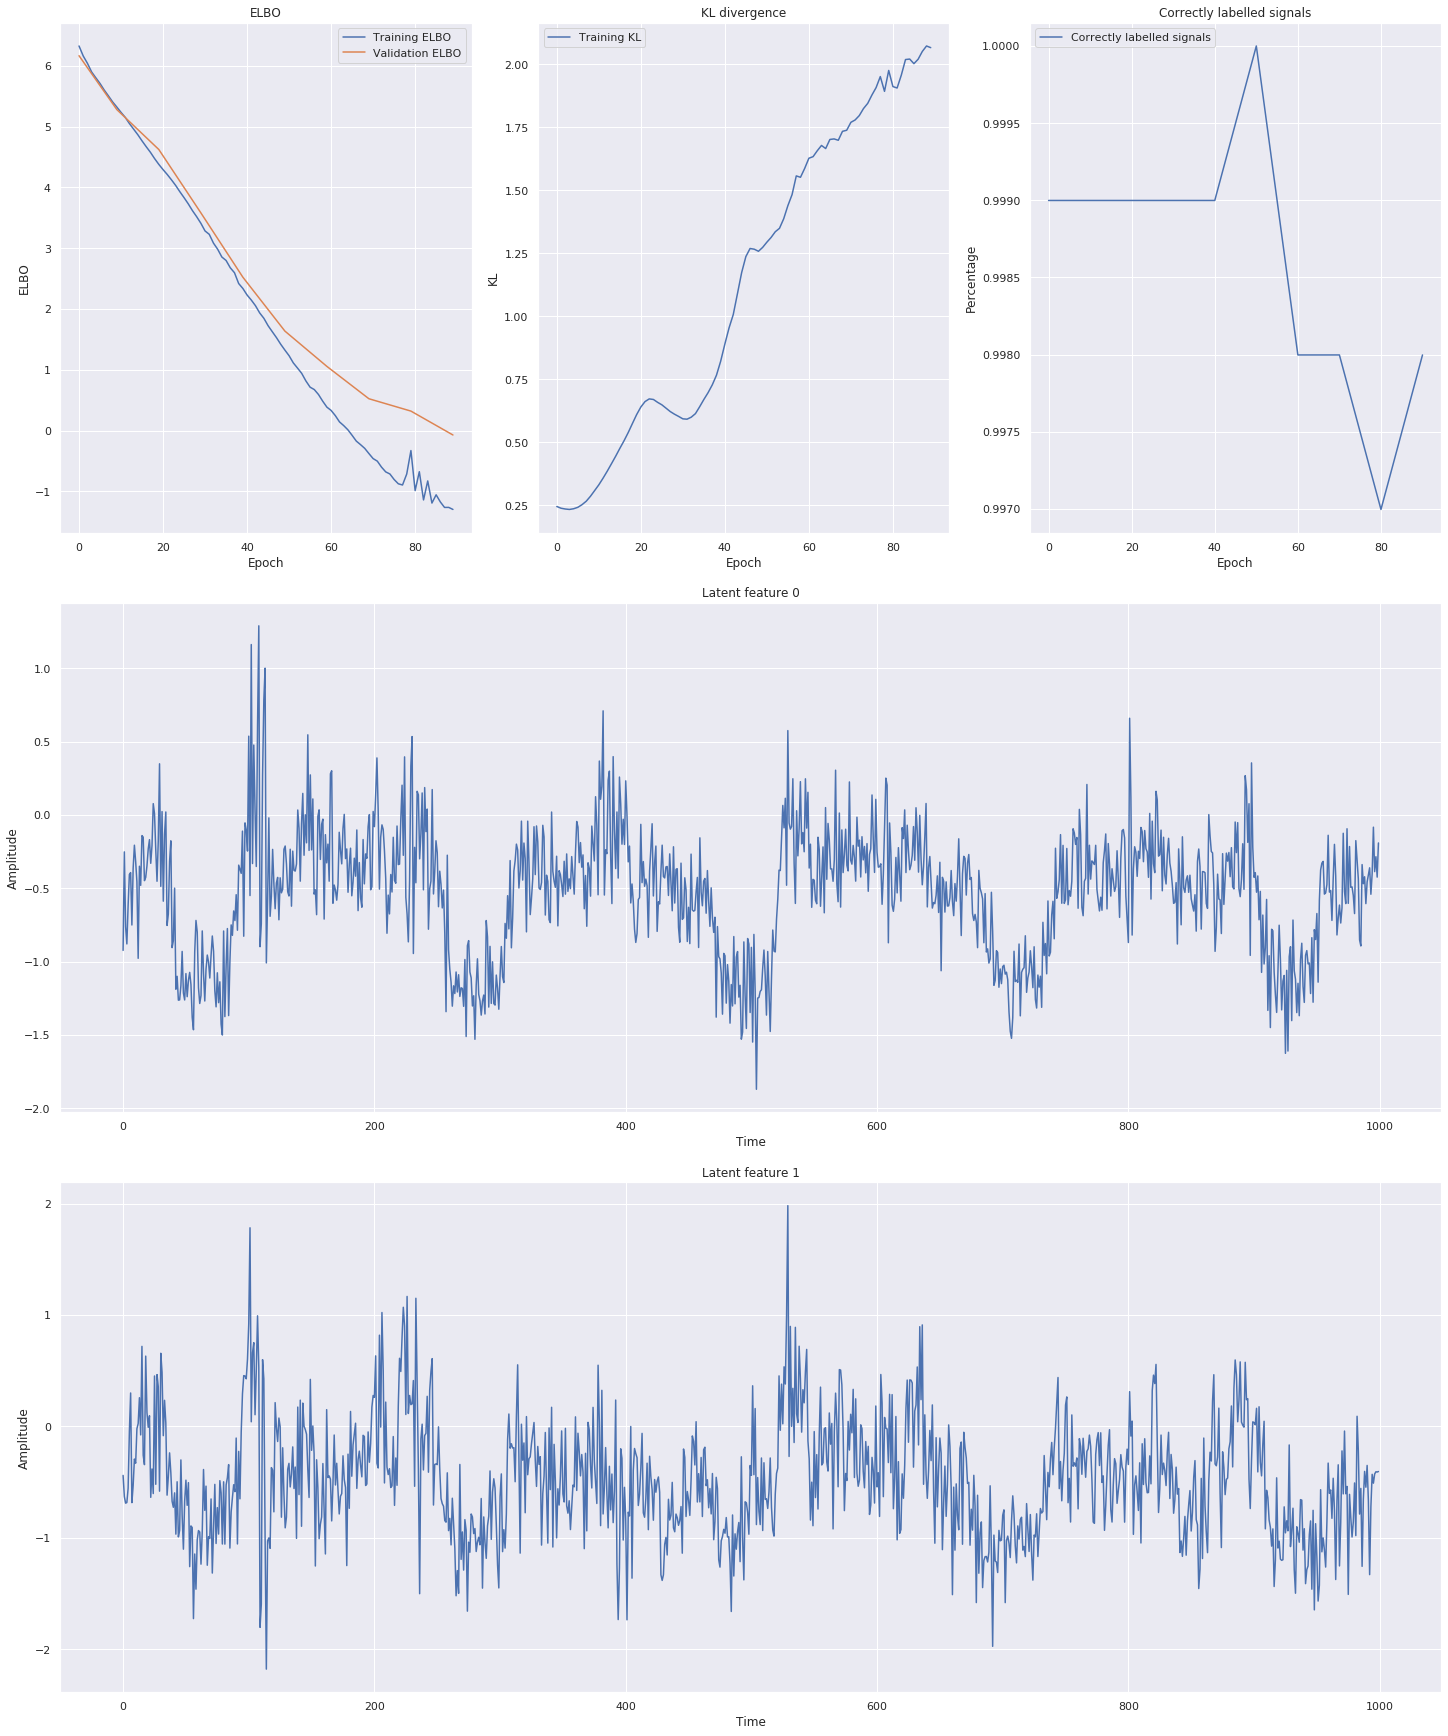

Epoch: 99


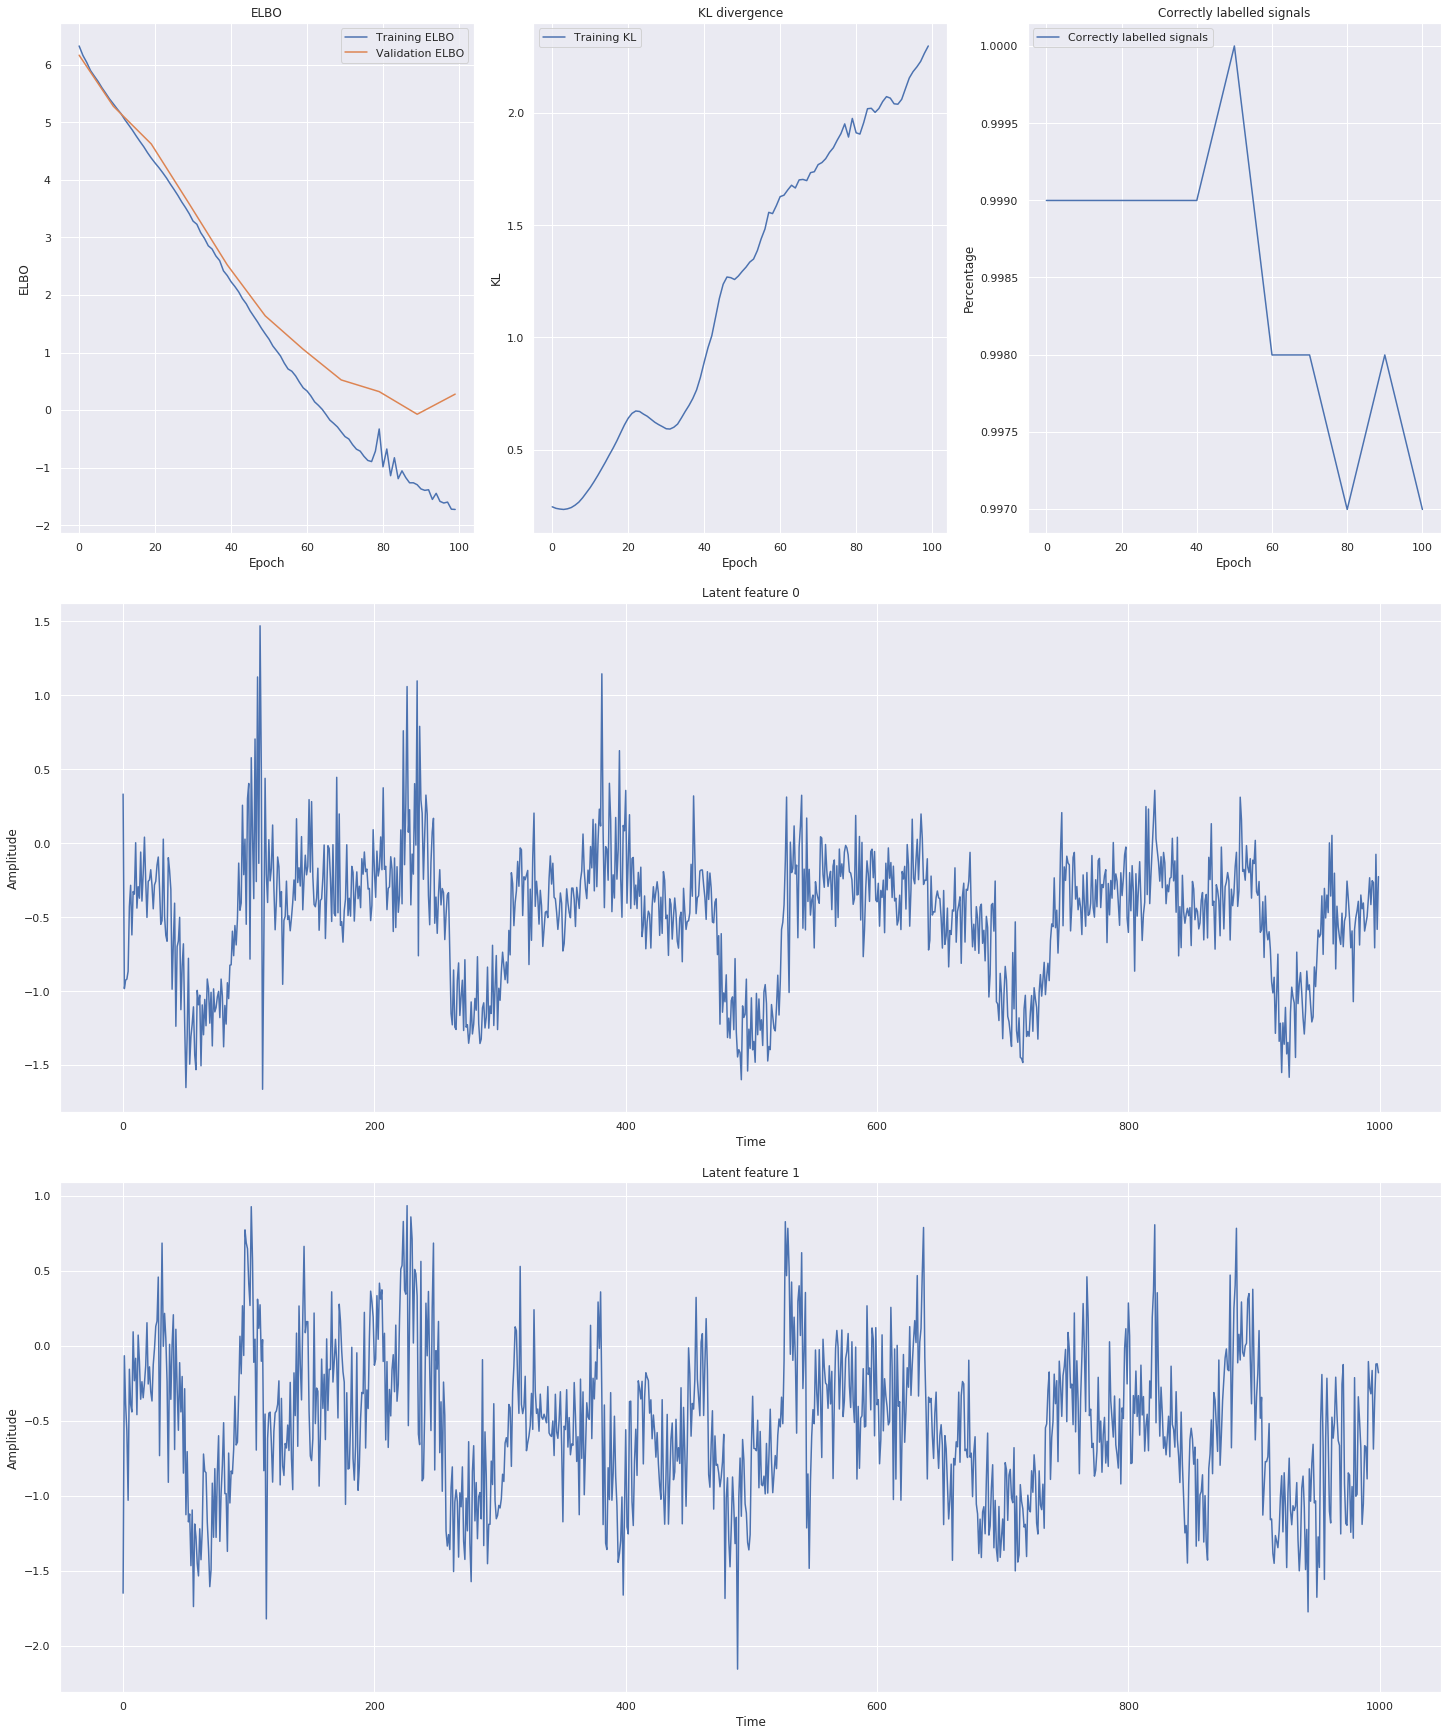

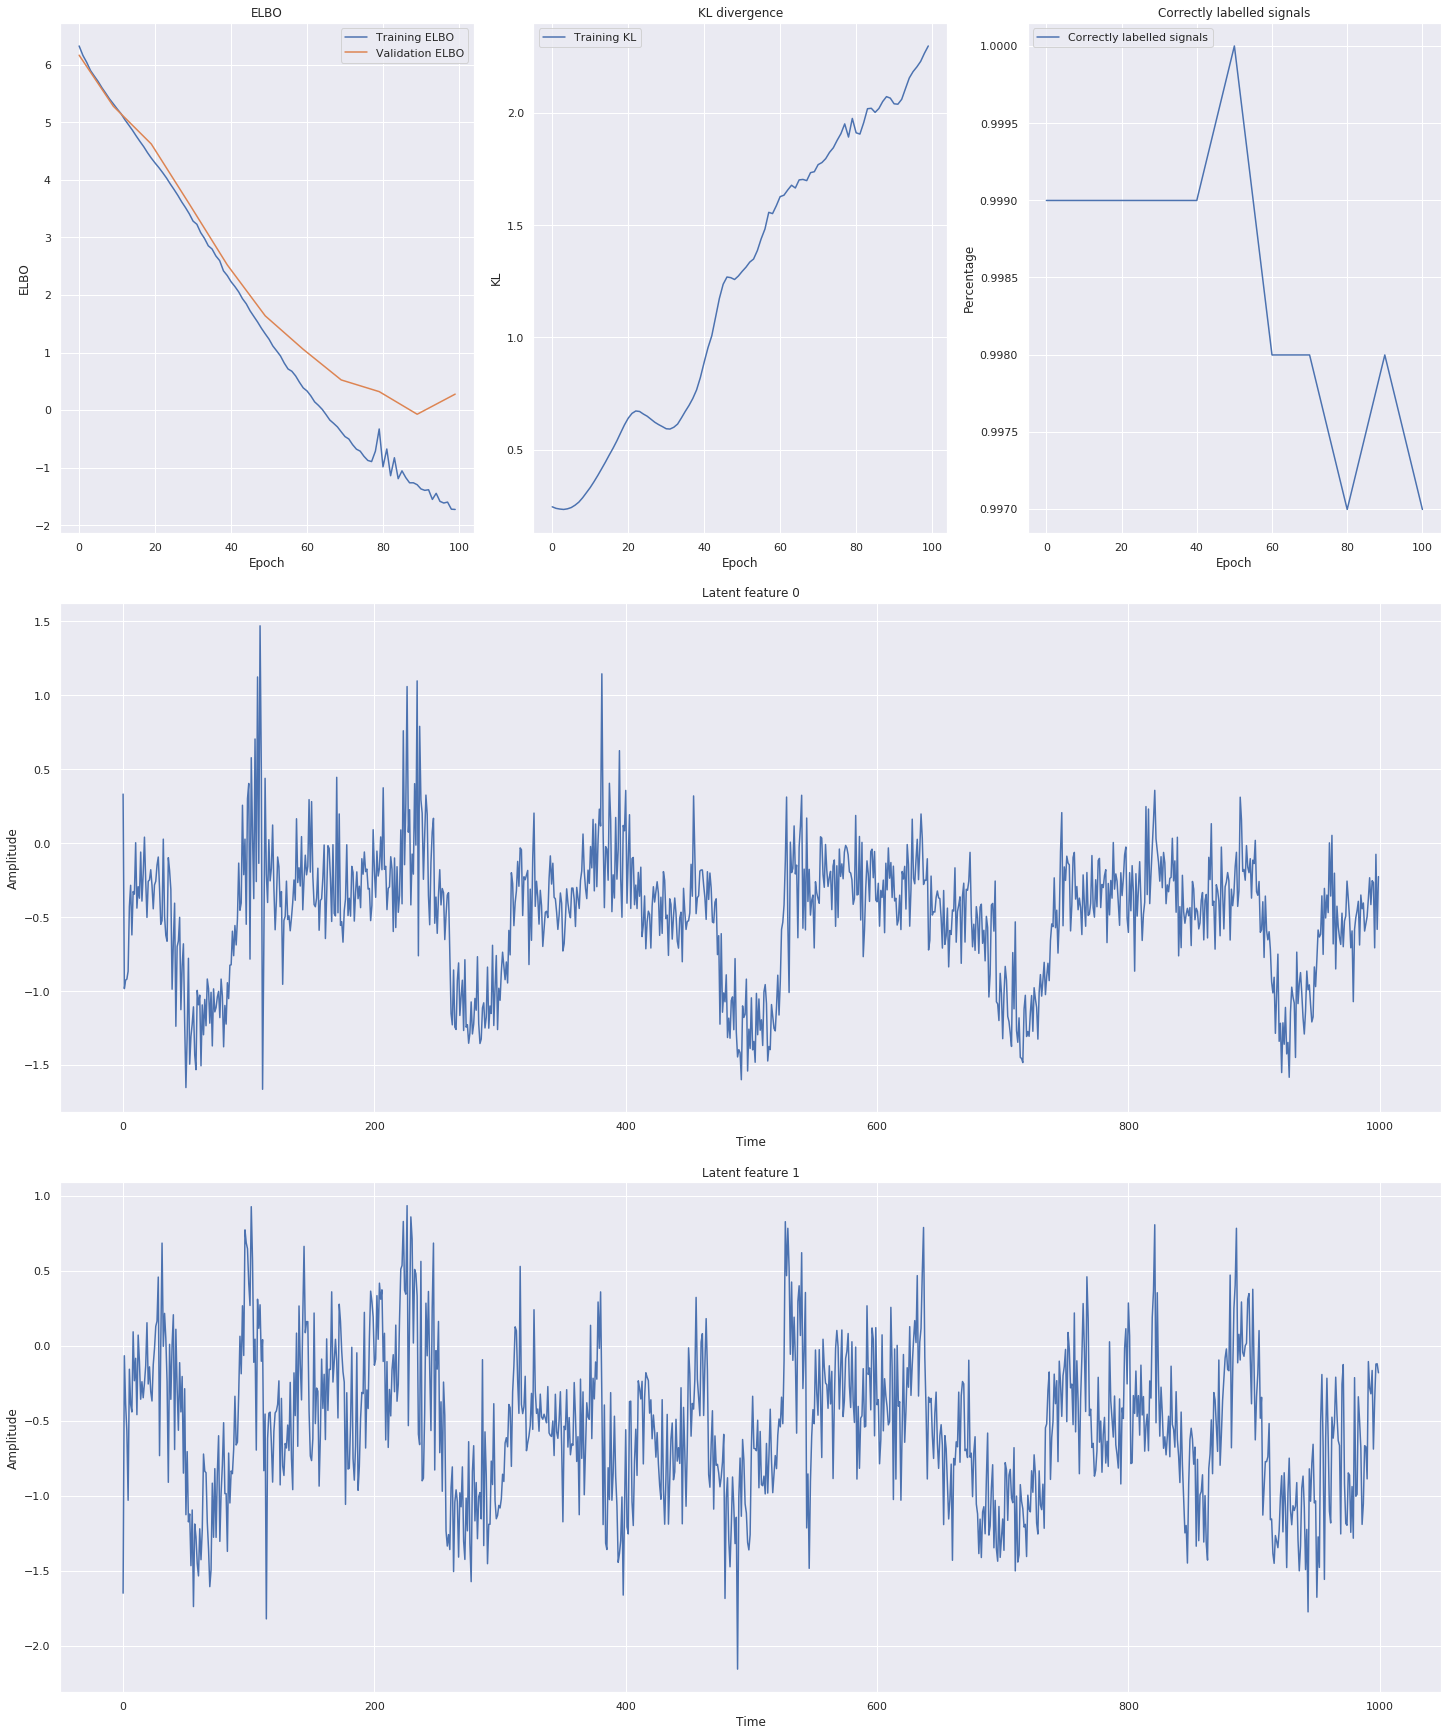

In [14]:
epochs_VAE = 100
params_distribution = 2
hidden_dim_gen = 8
hidden_dim_rec = 8
latent_dim = 2
torch.manual_seed(42)
np.random.seed(42)

#define the network
net = Variational_LSTM(features, params_distribution, hidden_dim_rec, hidden_dim_gen, latent_dim)
for param in net.parameters():
    param.data.uniform_(-0.5, 0.5)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_normal2d
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 1e-3)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)
# beta annealing to reduce the effect of KL going to zero
def sigmoid_beta_annealing(beta, epoch):
    k = 1.4 # steepness
    m = 40 # half time
    return (k**(epoch-m))/((k**(epoch-m))+1)

def heuristic_beta_annealing(beta, epoch):
    k1 = 1.05 # steepness
    k2 = 1.1
    m = 180 # half time
    if beta<0.75:
        return ((k1**(epoch-m))/4)*3
    else:
        return 1-((k2**(m-epoch))/4)
def linear_beta_annealing(beta, epoch):
    start_epoch = 30
    len_annealing = 20
    if epoch < start_epoch:
        return 0
    elif epoch < start_epoch + len_annealing:
        return min(beta + 1./len_annealing,1.)
    else:
        return 1
def no_beta_annealing(beta, epoch):
    return 0.05

def cyclic_beta_annealing(beta, epoch):
    M = 2
    L = epochs_VAE / M
    R = 0.75
    tau = (epoch % math.ceil(L))/L
    f_type = "linear" #linear, sigmoid
    if tau <= R:
        return increasing_function(tau, f_type, R)
    else:
        return 1
def increasing_function(tau, f_type, R):
    if f_type == "linear":
        return tau/R
    elif f_type == "sigmoid":
        k = 1.04 # steepness
        m = R/2 # half time
        return (k**(1000*(tau-m)))/((k**(1000*((tau-m))))+1)

chosen_annealing = no_beta_annealing

betas = []
beta = 0
for epoch in range(epochs_VAE):
    betas.append(chosen_annealing(beta, epoch))
    beta = betas[-1]
plt.figure(figsize = (20,10))
plt.title("Annealing of the KL term")
plt.xlabel("Epoch")
plt.ylabel("beta")
plt.plot(list(range(len(betas))), betas)


#run the training
net_state_dict, train_fig = train_network(device, train_loader, valid_dataset, epochs_VAE, net, \
                                          loss_function, optimizer, chosen_annealing, scheduler = scheduler, \
                                          p_anomaly = 1e-5)
net_state_dict_VAE = net_state_dict
train_fig_VAE = train_fig

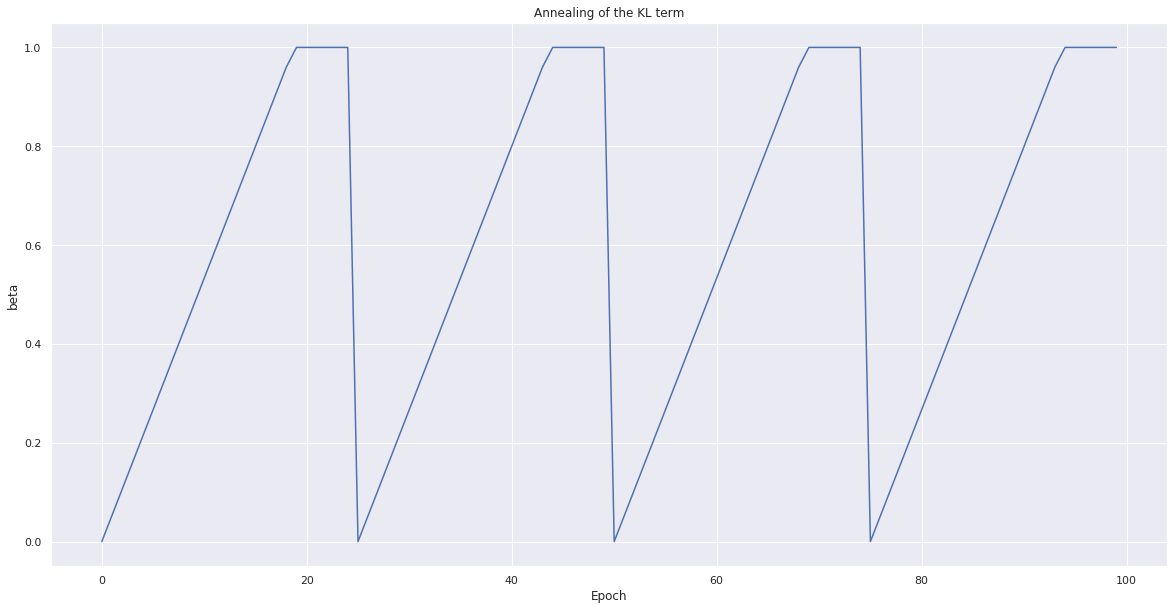

In [15]:
def cyclic_annealing(beta, epoch):
    M = 4
    L = epochs_VAE / M
    R = 0.75
    tau = (epoch % math.ceil(L))/L
    f_type = "linear" #linear, sigmoid
    if tau <= R:
        return increasing_function(tau, f_type, R)
    else:
        return 1
def increasing_function(tau, f_type, R):
    if f_type == "linear":
        return tau/R
    elif f_type == "sigmoid":
        k = 1.04 # steepness
        m = R/2 # half time
        return (k**(1000*(tau-m)))/((k**(1000*((tau-m))))+1)

betas = []
beta = 0
for epoch in range(epochs_VAE):
    betas.append(cyclic_annealing(beta, epoch))
    beta = betas[-1]
plt.figure(figsize = (20,10))
plt.title("Annealing of the KL term")
plt.xlabel("Epoch")
plt.ylabel("beta")
plt.plot(list(range(len(betas))), betas)

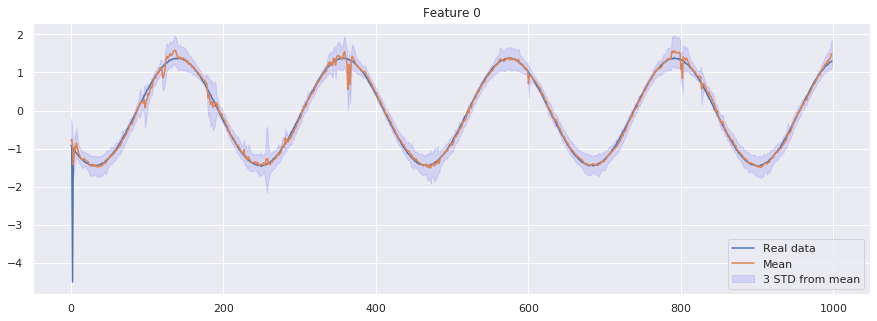

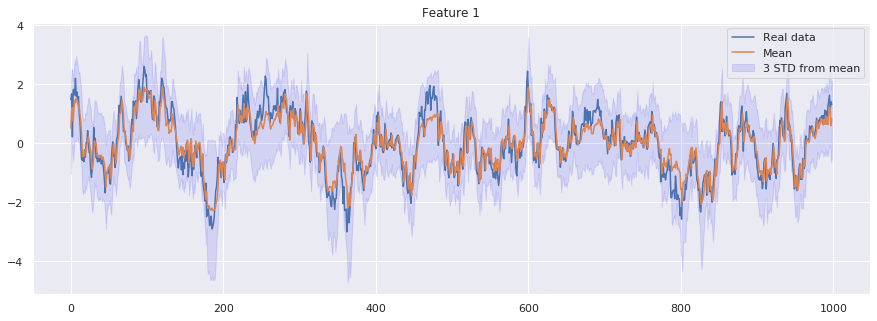

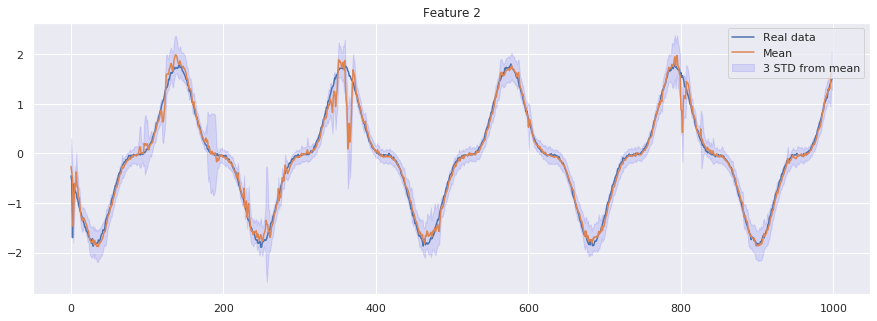

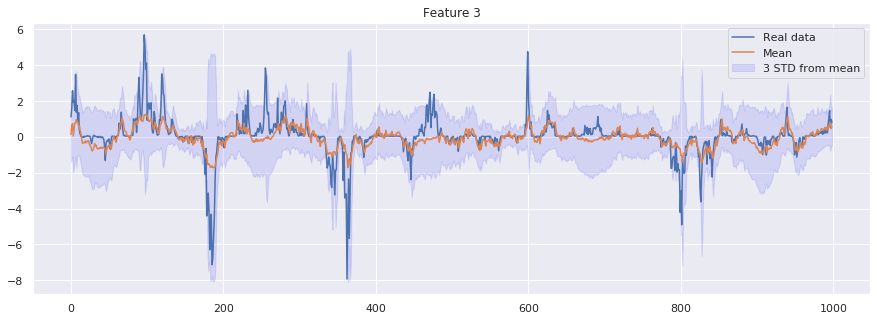

In [16]:
# start time of plotting
A = 0
# end time of plotting
B = 1000
# select the sequence to test the network on
sequence =  test_dataset.get_data()[0]
sequence = train_dataset.get_data()[0]
sequence = valid_dataset.get_data()[0]

with torch.no_grad():
    net.eval()
    # load the state of the trained network
    net.load_state_dict(net_state_dict)    
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    output_model_figs_VAE = []
    
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        fig = plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        output_model_figs_VAE.append(fig)
        plt.show()


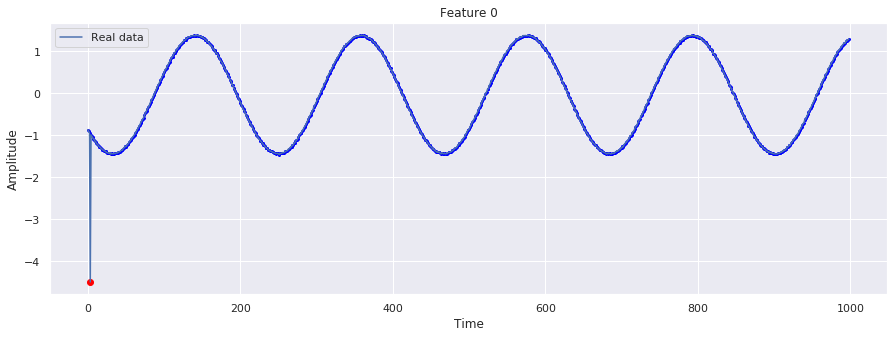

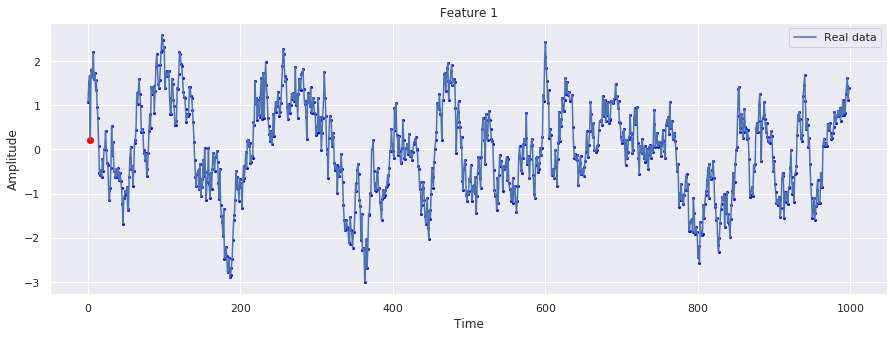

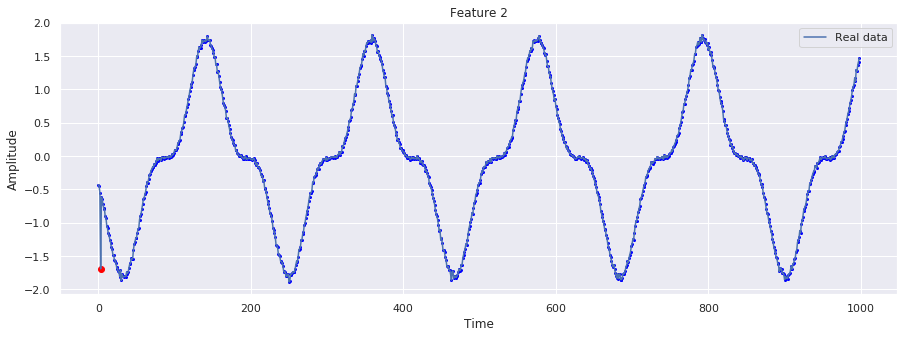

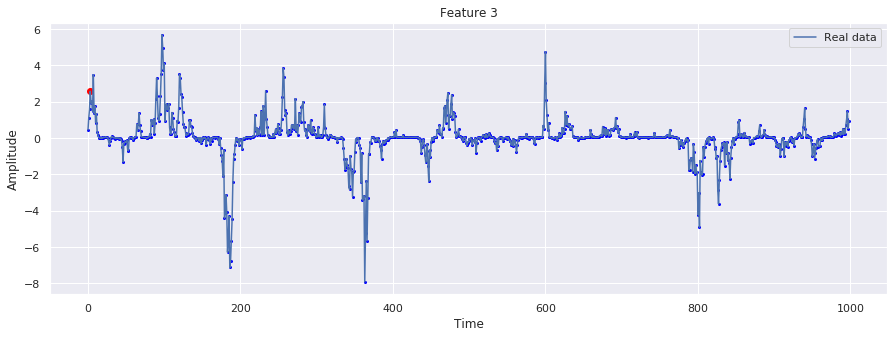

In [17]:
sequence = valid_dataset.get_data()[0]
#sequence = test_dataset.get_data()[0]

percentage = 0.0001
anomaly_data = detect_anomalies_VAE(sequence, net, device, percentage/100)
anomalies_figs_VAE = plot_anomalies(anomaly_data, sequence, 0, 1000)

In [18]:
predictions = anomaly_data["outlier_label"]
ground_truth = valid_dataset.get_data()[1]
#ground_truth = test_dataset.get_data()[1]
correct = 0
total = len(predictions) - 1
false_positives = 0
false_negatives = 0
anomaly_count = 0
for i in range(total):
    if ground_truth[i] == True:
        anomaly_count += 1
    if predictions[i] == ground_truth[i]:
        correct += 1
    elif predictions[i] == False:
        false_negatives += 1
    elif predictions[i] == True:
        false_positives += 1
accuracy_VAE = {
    # number of labels correctly predicted
    "correct": correct,  
    # false positives (the datapoint was not an anomaly but it was predicted as one)
    "false_positives": false_positives,
    # false negatives (the datapoint was an anomaly abut it was not predicted as one)
    "false_negatives": false_negatives,
    # total number of datapoints in the sequence
    "total": total,
    # total number of anomalies
    "anomaly_count": anomaly_count
}
print(accuracy_VAE)

{'correct': 999, 'false_positives': 0, 'false_negatives': 0, 'total': 999, 'anomaly_count': 1}


# Baseline LSTM model

Training has started.
Epoch: 0


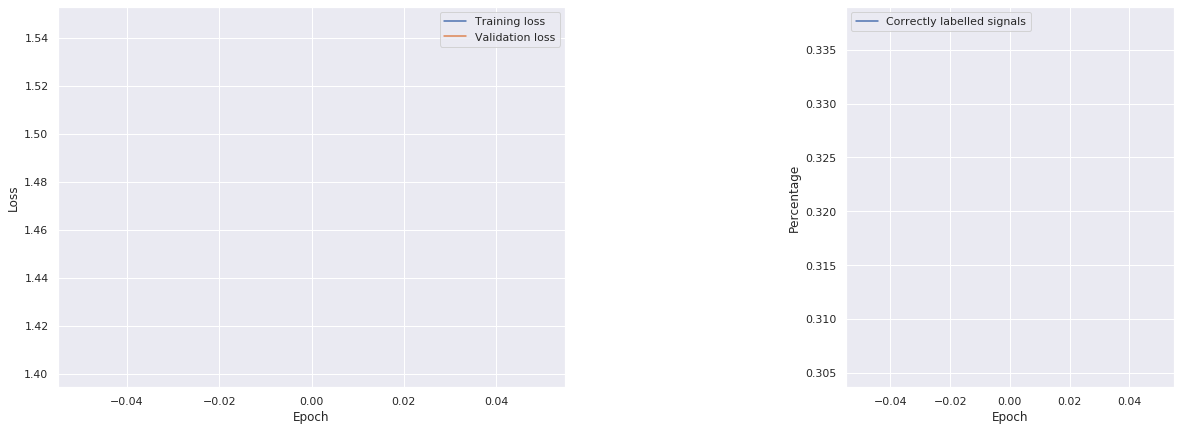

Epoch: 9


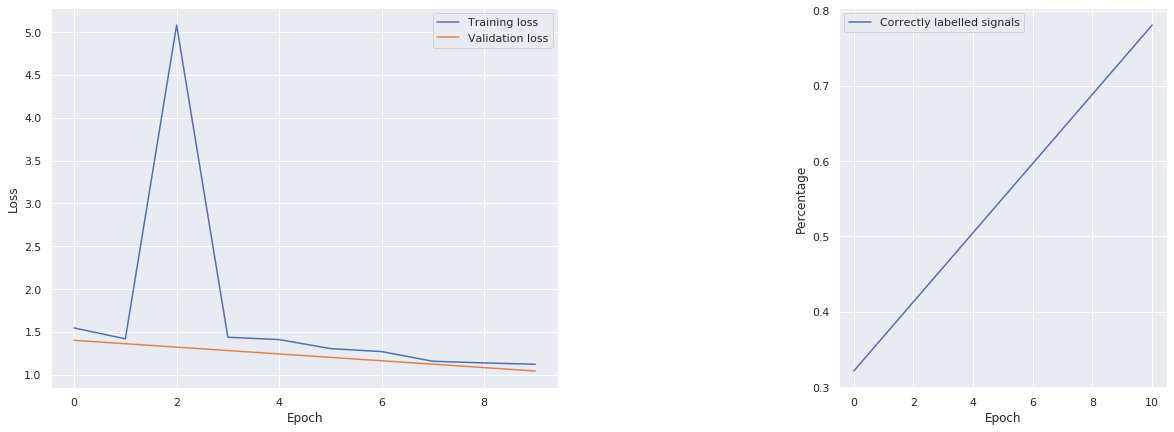

Epoch: 19


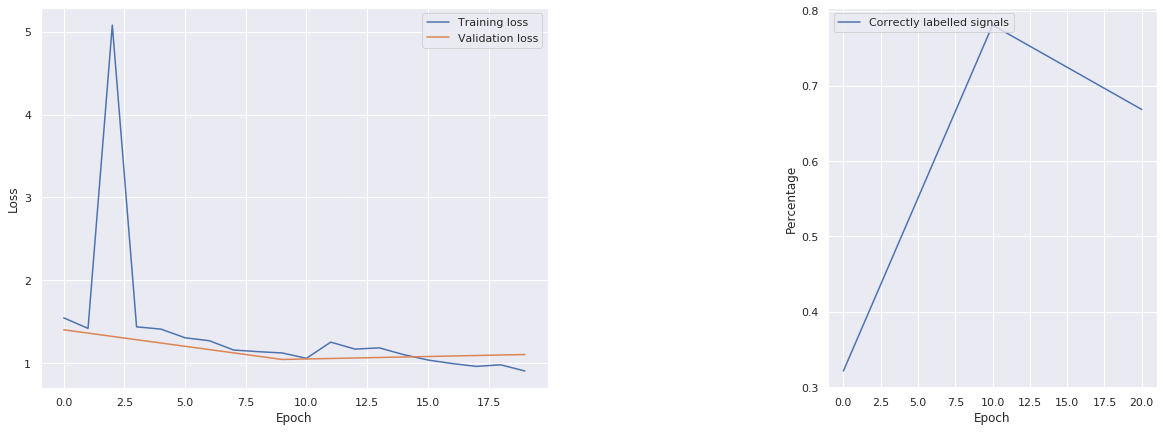

Epoch: 29


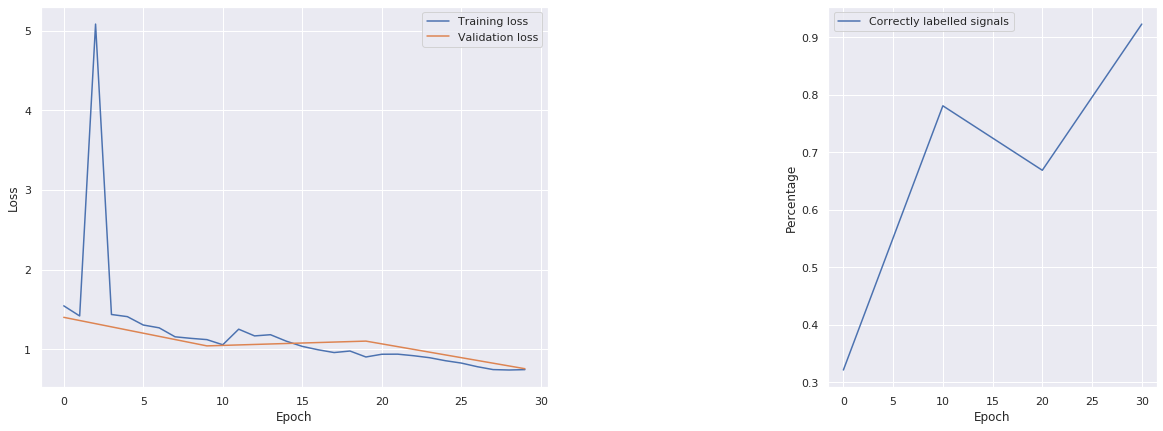

Epoch: 39


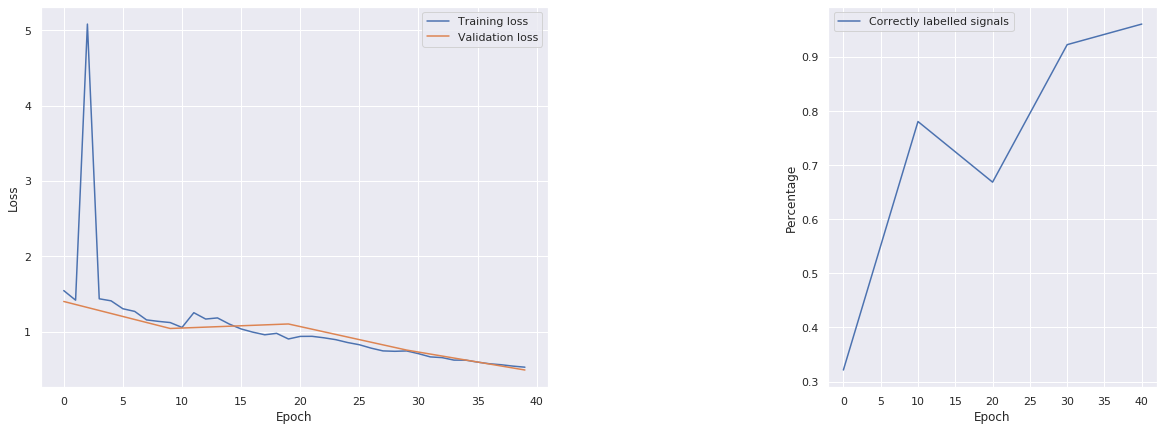

Epoch: 49


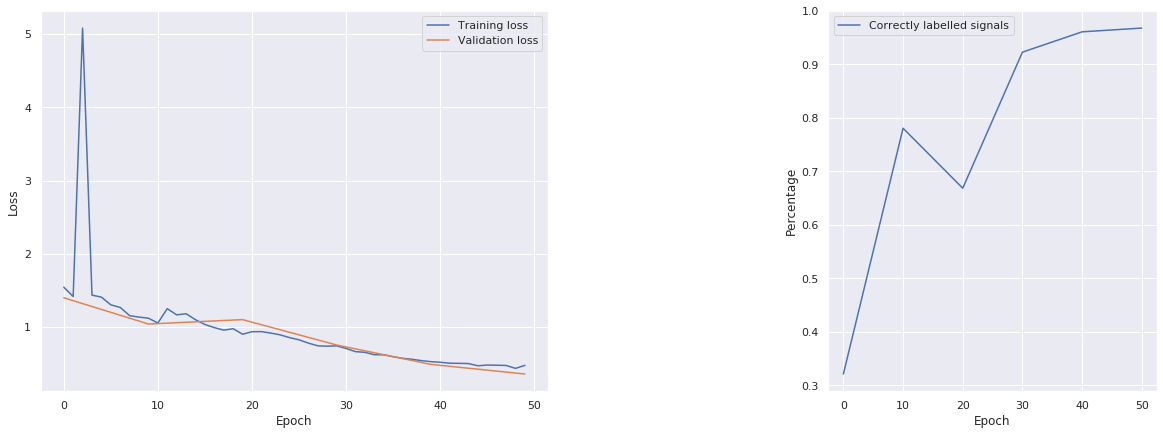

Epoch: 59


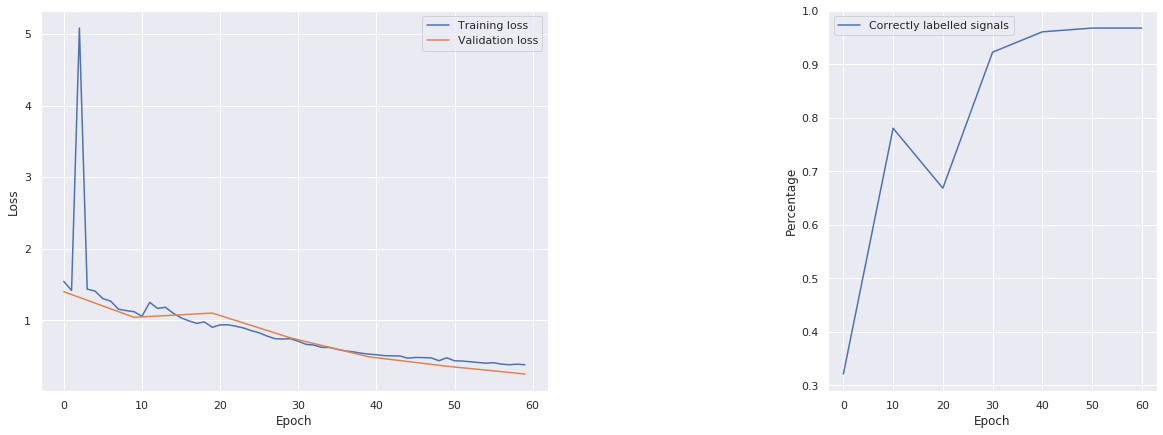

Epoch: 69


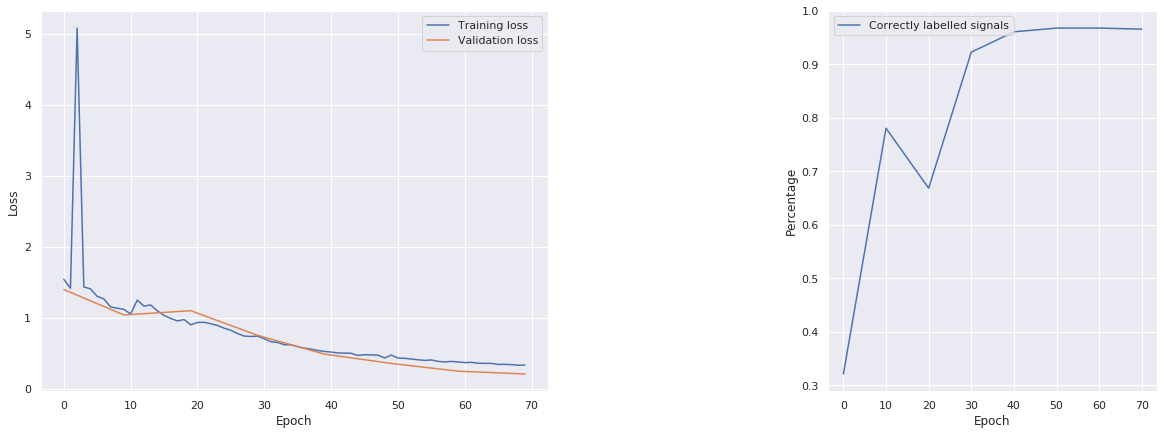

Epoch: 79


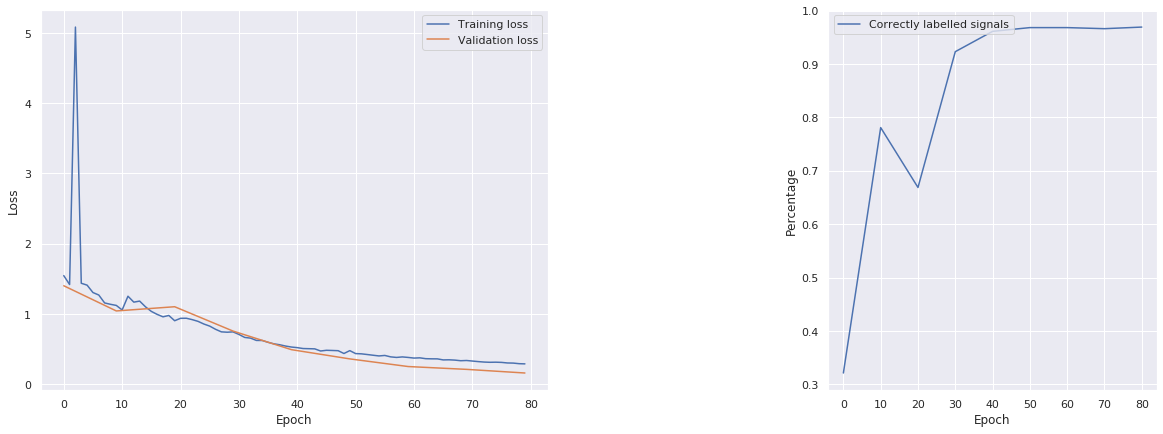

Epoch: 89


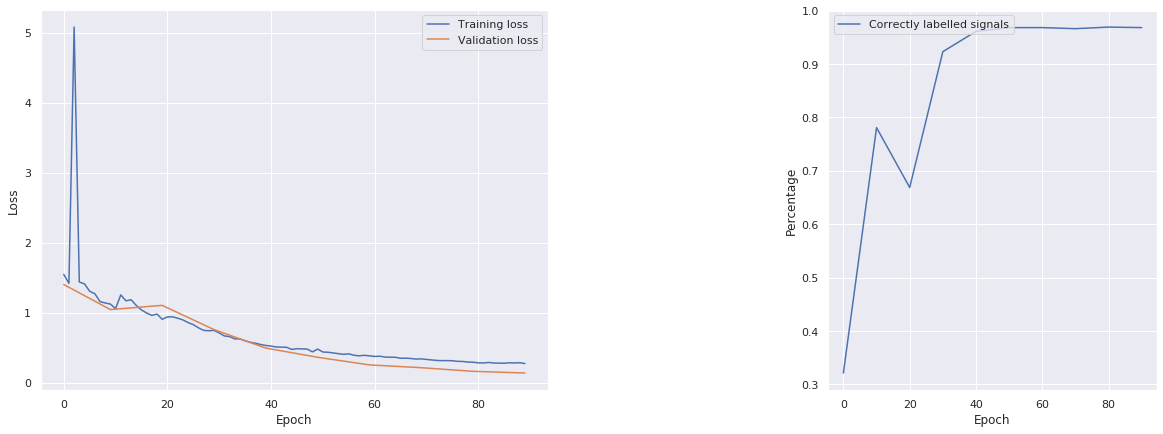

Epoch: 99


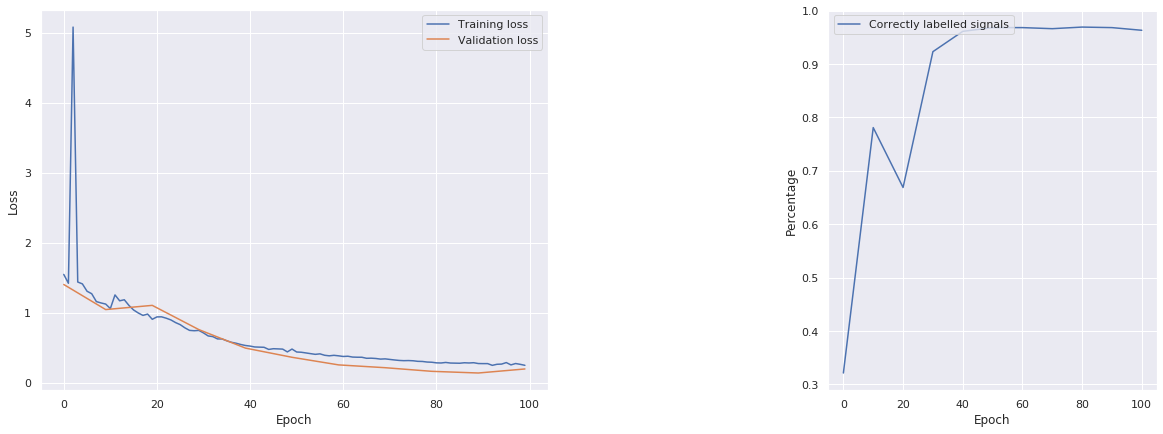

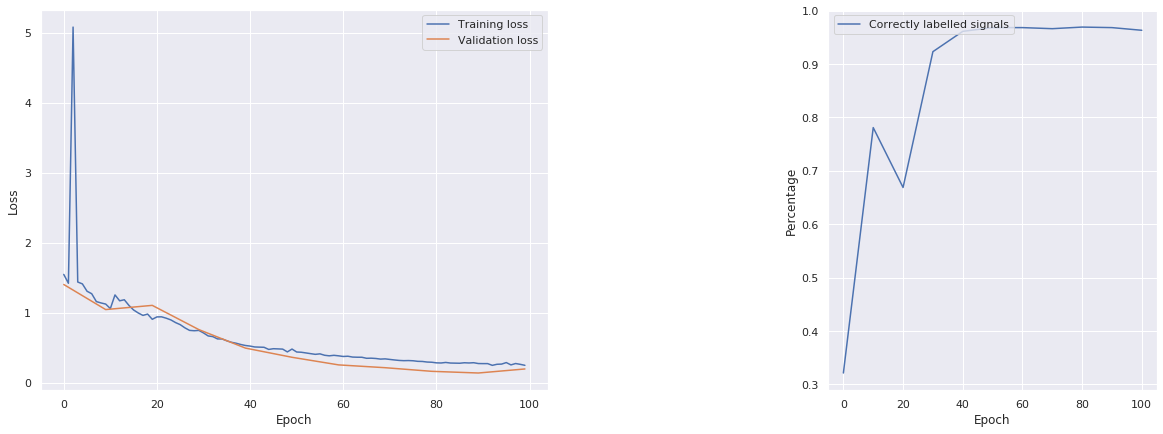

In [12]:
epochs_LSTM = 100
params_distribution = 2
hidden_layer_size = 256

#define the network
net = Standard_LSTM(features, params_distribution, hidden_layer_size)
#push it to the correct device
net.to(device)
#define the loss function
loss_function = loss_function_normal
#define the optimizer with the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.0001)
#here we define the scheduler
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

#run the training
net_state_dict, train_fig = train_network(device, train_loader, valid_dataset , epochs_LSTM, net, loss_function,\
                                          optimizer, scheduler= scheduler)
net_state_dict_LSTM = net_state_dict
train_fig_LSTM = train_fig
plt.show()

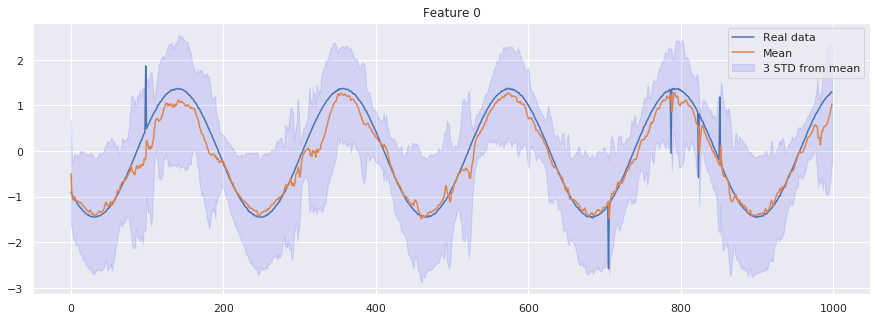

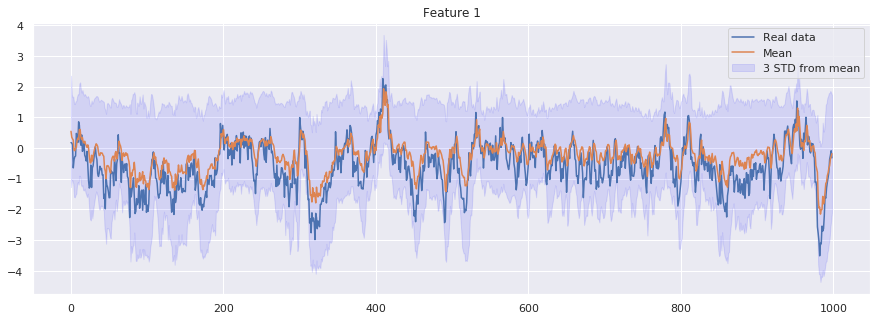

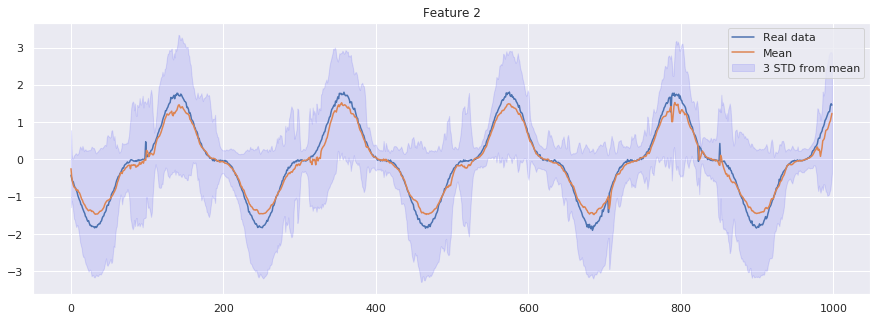

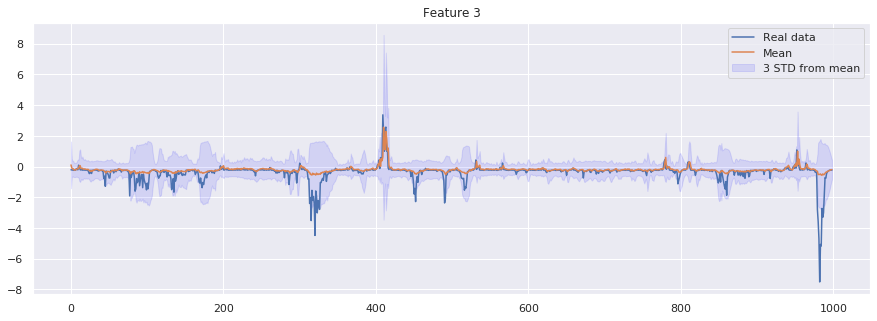

In [13]:
# start time of plotting
A = 0
# end time of plotting
B = 1000
# select the sequence to test the network on
sequence = test_dataset.get_data()[0]
sequence = train_dataset.get_data()[0]
sequence = valid_dataset.get_data()[0]

with torch.no_grad():
    # load the state of the trained network
    net.load_state_dict(net_state_dict)    
    
    # get it to the device and  put the batch dimension
    prepared_sequence = (sequence).to(device).unsqueeze(0)
    
    # run the model
    output_model = net(prepared_sequence, device)

    # extract the parameters at each time step
    mu, logvar = torch.chunk(output_model["params"], 2, dim=-1)
    std_dev = torch.exp(logvar/2)

    # PLOTTING
    # extract start and end points
    Ti = max(0, A)
    Tf = min(B, sequence.shape[0])
    time_axis = list(range(Ti,Tf-1))
    
    output_model_figs_LSTM = []
    
    for dimension in range(sequence.shape[1]):
        mean = torch.mean(mu, dim = 1)[Ti:Tf-1,dimension].cpu()
        std = 3*torch.mean(std_dev, dim = 1)[Ti:Tf-1,dimension].cpu()

        fig = plt.figure(figsize = (15,5))
        plt.title("Feature {}".format(dimension))
        plt.plot(time_axis, sequence[Ti+1:Tf,dimension], label = "Real data")
        plt.plot(time_axis, mean, label="Mean")
        plt.fill_between(time_axis, mean - std, mean + std,
                 color='blue', alpha=0.1, label="3 STD from mean")
        plt.legend()
        output_model_figs_LSTM.append(fig)
        plt.show()


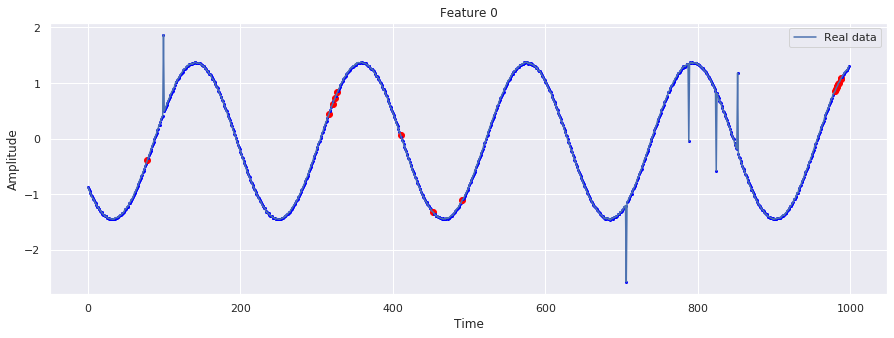

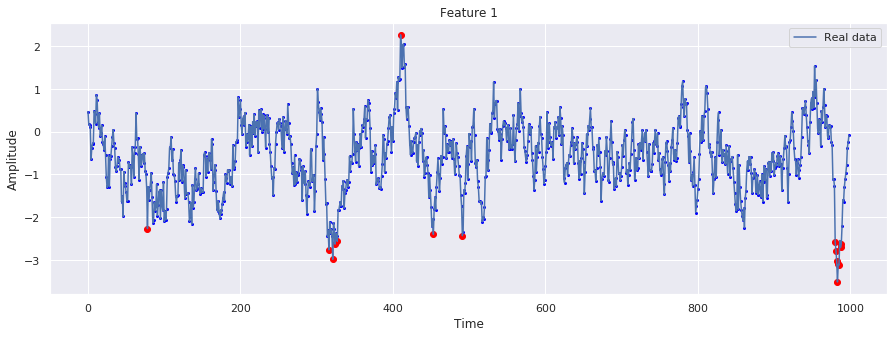

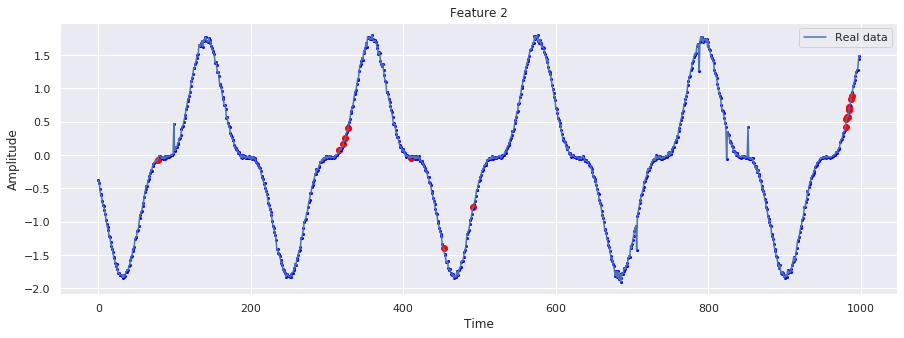

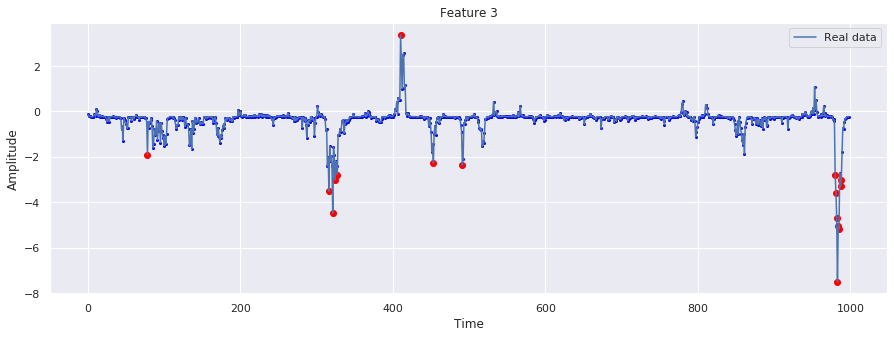

In [14]:
sequence = valid_dataset.get_data()[0]
#sequence = test_dataset.get_data()[0]

percentage = 0.05
anomaly_data = detect_anomalies(sequence, net, device, percentage/100, False)
anomalies_figs_LSTM = plot_anomalies(anomaly_data, sequence, 0, 1000)

In [15]:
predictions = anomaly_data["outlier_label"]
ground_truth = valid_dataset.get_data()[1]
#ground_truth = test_dataset.get_data()[1]

correct = 0
total = len(predictions) - 1
false_positives = 0
false_negatives = 0
anomaly_count = 0
for i in range(total):
    if ground_truth[i] == True:
        anomaly_count += 1
    if predictions[i] == ground_truth[i]:
        correct += 1
    elif predictions[i] == False:
        false_negatives += 1
    elif predictions[i] == True:
        false_positives += 1
accuracy_LSTM = {
    # number of labels correctly predicted
    "correct": correct,  
    # false positives (the datapoint was not an anomaly but it was predicted as one)
    "false_positives": false_positives,
    # false negatives (the datapoint was an anomaly abut it was not predicted as one)
    "false_negatives": false_negatives,
    # total number of datapoints in the sequence
    "total": total,
    # total number of anomalies
    "anomaly_count": anomaly_count
}
print(accuracy_LSTM)

{'correct': 978, 'false_positives': 16, 'false_negatives': 5, 'total': 999, 'anomaly_count': 5}


In [16]:
run_name = "syntheticdataset_correlated_smaller_anomalies"

save_setup(run_name, \
               raw_signals, train_dataset, valid_dataset, test_dataset, net_state_dict_VAE, net_state_dict_LSTM, \
               anomalies_figs_LSTM, anomalies_figs_VAE, output_model_figs_LSTM, output_model_figs_VAE, \
               train_fig_LSTM, train_fig_VAE, \
               epochs_LSTM, hidden_layer_size, \
               epochs_VAE, params_distribution, hidden_dim_gen, hidden_dim_rec, latent_dim, \
               anomalies_m, anomalies_p, \
               accuracy_LSTM, accuracy_VAE)

Successfully created the directory runs/20191224_1936-syntheticdataset_correlated_smaller_anomalies 
